In [3]:
#🔵
main_path = '/Users/stanislavkrupnov/Jup.Notebook'

In [ ]:
#🟠
main_path = '/content/drive/Othercomputers/Mac/Jup.Notebook'

# Что в ноутбуке

Я провожу стекинг моделей ранжирования с целью улчшения метрики второго этапа  
рек.системы.  
Будут 4 попытки создания мета-модели  
Победил 4 вариант, где мета-моделью выступил бейзлайн sklearn LogisticRegression  

# IMPORT

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.7 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
import lightgbm as lgb

In [ ]:
import os
import sys
from tqdm import tqdm
import glob
from IPython import display
import pyarrow.parquet as pq
import pickle
import pandas as pd
import gc
import numpy as np
import itertools
from datetime import datetime as dt
import polars as pl
import shutil
from sklearn.model_selection import GroupKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ndcg_score
import joblib
from sklearn.metrics import average_precision_score
import time

In [ ]:
import gdown
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random_state = 42

In [ ]:
import catboost
from catboost import CatBoostRanker, Pool

# Функции

In [ ]:
def metric_eval (predictions, valid, id2type):


    valid.type = valid.type.map(lambda idx: id2type[idx])
    ground_truth = valid.groupby(['session', 'type'])['aid'].apply(list)
    ground_truth = ground_truth.reset_index().rename(columns={'aid': 'labels'})
    ground_truth.loc[ground_truth.type == 'clicks', 'labels'] = ground_truth.loc[ground_truth.type == 'clicks', 'labels'].str[:1]

    submission_with_gt = predictions.merge(ground_truth[['session', 'type', 'labels']], how='left', on=['session', 'type'])

    submission_with_gt = submission_with_gt[~submission_with_gt.labels_y.isna()]

    submission_with_gt['hits'] = submission_with_gt.apply(lambda df: len(set(df.labels_x).intersection(set(df.labels_y))), axis=1)

    submission_with_gt['gt_count'] = submission_with_gt.labels_y.str.len().clip(0,20)

    recall_per_type = submission_with_gt.groupby(['type'])['hits'].sum() / submission_with_gt.groupby(['type'])['gt_count'].sum()
    local_validation_score = (recall_per_type * pd.Series({'clicks': 0.10, 'carts': 0.30, 'orders': 0.60})).sum()

    return local_validation_score

In [ ]:
def read_parquets(path):
    # Список файлов Parquet
    file_list = glob.glob(path)

    # Создание пустого DataFrame для сбора данных
    tr_candidates = pd.DataFrame()

    # Цикл для чтения и объединения файлов
    for file in tqdm(file_list):
      # Чтение файла Parquet во временный DataFrame
      df_ = pd.read_parquet(file)

      # Объединение временного DataFrame с основным датасетом
      tr_candidates = pd.concat([tr_candidates, df_], ignore_index=True)

    return tr_candidates

In [ ]:
def repack_data(X_valid, y_valid, y_preds_valid):
    # Добавляю к меткам соответ.сессии, чтобы можно было ранжировать
    # внутри каждой группы-сессии
    df = pd.DataFrame({'session': X_valid['session'], 'true': y_valid, 'preds': y_preds_valid})

    # Сортируйте DataFrame по 'session' и 'preds' в убывающем порядке
    sorted_df = df.sort_values(by=['session', 'preds'], ascending=[True, False])

    # Группируйте по 'session' и объедините 'true' и 'preds' в списки
    grouped_data = sorted_df.groupby('session').agg({'true': list, 'preds': list}).reset_index()

    # Извлечение списков и преобразование их в массивы NumPy
    y_true_repack = grouped_data['true'].to_numpy()
    y_preds_repack = grouped_data['preds'].to_numpy()

    return y_true_repack, y_preds_repack

In [ ]:
def average_precision(y_true, y_pred):
    true_positives = 0
    precision_at_rank = []

    for i, (actual, predicted) in enumerate(zip(y_true, y_pred), start=1):
        if actual == 1:
            true_positives += 1
            precision_at_rank.append(true_positives / i)
    if not precision_at_rank:
        return 0
    return sum(precision_at_rank) / len(precision_at_rank)

def mean_average_precision(y_true, y_pred):

    average_precisions = []

    for actual, predicted in tqdm(zip(y_true, y_pred), total=len(y_true)):
        ap = average_precision(actual, predicted)
        average_precisions.append(ap)

    return np.mean(average_precisions)

# Метрика на базовых алгоритмах

Поcчитана ранее в ноутбуке Baselin, Tuning - Recall@20 :
- 'lgbm': 0.52485557,
- 'lgbm_tun' : 0.5250579,
- 'catboost': 0.52711695
- **'catboost_tun' : 0.52725659**  
Беру за первый вариант эти 4 базовых алгоритма

# Загрузка данных

**Тренировочные данные**

**Кандидаты были downsampled ранее, тут буду использовать как раз эту их версию, чтобы ускорить процесс**

In [ ]:
tr_candidates_clicks = pd.read_parquet(f'{main_path}/tr/ver_6/downsampled/tr_candidates_clicks.parquet')
tr_candidates_clicks = tr_candidates_clicks.sort_values('session')

tr_candidates_carts = pd.read_parquet(f'{main_path}/tr/ver_6/downsampled/tr_candidates_carts.parquet')
tr_candidates_carts = tr_candidates_carts.sort_values('session')

tr_candidates_orders = pd.read_parquet(f'{main_path}/tr/ver_6/downsampled/tr_candidates_orders.parquet')
tr_candidates_orders = tr_candidates_orders.sort_values('session')

**Тестовые данные**

In [ ]:
test_candidates_clicks = read_parquets(f'{main_path}/lv/ver_6/test_candidates_clicks/*')
test_candidates_clicks = test_candidates_clicks.sort_values('session')
test_candidates_clicks = test_candidates_clicks.reset_index(drop = True)

test_candidates_carts = read_parquets(f'{main_path}/lv/ver_6/test_candidates_carts/*')
test_candidates_carts = test_candidates_carts.sort_values('session')
test_candidates_carts = test_candidates_carts.reset_index(drop = True)

test_candidates_orders = read_parquets(f'{main_path}/lv/ver_6/test_candidates_orders/*')
test_candidates_orders = test_candidates_orders.sort_values('session')
test_candidates_orders = test_candidates_orders.reset_index(drop = True)

100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


In [ ]:
# test_candidates_clicks['type_counts_clicks']
# test_candidates_clicks.shape
tr_candidates_clicks.shape

(6770171, 24)

**Тренировочные метки**

In [ ]:
targets = pd.read_parquet(f'{main_path}/s/targets.parquet')

**Тестовые метки**

In [ ]:
test_labels_loc = pd.read_parquet(f'{main_path}/s/test_labels_loc.parquet')

**Создание пустых мета-признаков**

In [ ]:
meta_X_clicks = pd.DataFrame()
meta_X_test_clicks = pd.DataFrame()

meta_X_carts = pd.DataFrame()
meta_X_test_carts = pd.DataFrame()

meta_X_orders = pd.DataFrame()
meta_X_test_orders = pd.DataFrame()

In [ ]:
# Эти столбцы в мета-признаках нужны для передачи размеров каждой группы-сессии
# при обучении мета-модели, они будут удалены непосредственно перед .fit()
meta_X_clicks[['session','aid', 'target']] = tr_candidates_clicks[['session',
                                                                     'aid',
                                                                      'target']]
                                                                      .copy()
meta_X_test_clicks[['session','aid', 'target']] = test_candidates_clicks[['session',
                                                                        'aid',
                                                                        'target']]
                                                                        .copy()

meta_X_carts[['session','aid', 'target']] = tr_candidates_carts[['session','aid',
                                                                 'target']].copy()
meta_X_test_carts[['session','aid', 'target']] = test_candidates_carts[['session','aid',
                                                                      'target']].copy()

meta_X_orders[['session','aid', 'target']] = tr_candidates_orders[['session','aid',
                                                                   'target']]
                                             .copy()
meta_X_test_orders[['session','aid', 'target']] = test_candidates_orders[['session',
                                                                        'aid',
                                                                        'target']]
                                                  .copy()

**Загрузка существующих**

In [ ]:
meta_X_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

# LGBM

 ## Tuning

In [ ]:
lgbm_candidates = tr_candidates_clicks
# lgbm_candidates = tr_candidates_carts
# lgbm_candidates = tr_candidates_orders

In [ ]:
def objective(trial, data, random_state):
    """
    Объектная функция Optuna для настройки гиперпараметров модели LightGBM Ranker.

    Параметры:
    - trial: Объект Optuna trial для оптимизации гиперпараметров.
    - data: DataFrame, содержащий тренировочные данные.
    - random_state: Случайное зерно для воспроизводимости.

    Возвращает:
    - ndcg_mean: Средний показатель NDCG@5 по всем фолдам.
    """

    # Определение гиперпараметров LightGBM, подлежащих настройке
    lgbm_params = {
        'objective':
        'lambdarank',
        'boosting_type':
        'gbdt',
        'verbosity':
        2,
        'verbose_eval':
        100,
        'n_estimators':
        trial.suggest_categorical("n_estimators", [888]),
        'learning_rate':
        trial.suggest_categorical("learning_rate", [0.016570454970422126]),
        'max_depth':
        trial.suggest_int('max_depth', 2, 13),
        'min_split_gain':
        trial.suggest_float('min_split_gain', 0.0, 1.0),
        'reg_lambda':
        trial.suggest_float('reg_lambda', 0.0, 2.0),
        'random_state':
        random_state
    }

    # Выполнение 5-кратной перекрестной проверки с использованием GroupKFold
    skf = GroupKFold(n_splits=5)
    FEATURES = data.columns[:-1]
    scores = []

    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(data, data['target'], groups=data['session'])):
        print('fold_', fold)

        # Инициализация модели LightGBM Ranker
        ranker = lgb.LGBMRanker(**lgbm_params)

        # Подготовка тренировочного и валидационного наборов данных
        X_train = data.iloc[train_idx][FEATURES]
        y_train = data.iloc[train_idx]['target']
        X_valid = data.iloc[valid_idx][FEATURES]
        y_valid = data.iloc[valid_idx]['target']

        group_id_tr = X_train.groupby('session').size().tolist()
        X_train = X_train.iloc[:,
                               2:]  # Исключить ['session', 'aid'] для обучения
        group_id_val = X_valid.groupby('session').size().tolist()
        X_valid = X_valid.iloc[:, 2:]

        print('Теперь подгоняем модель.')

        # Обучение модели с преждевременной остановкой на основе NDCG@5
        early_stopping_callback = lgb.early_stopping(stopping_rounds=100)
        ranker = ranker.fit(X_train,
                            y_train,
                            group=group_id_tr,
                            eval_set=[(X_valid, y_valid)],
                            eval_group=[group_id_val],
                            callbacks=[early_stopping_callback])

        print(ranker.best_score_)
        ndcg = ranker.best_score_['valid_0']['ndcg@5']
        print(f'fold_{fold}: NDCG = {ndcg}')
        scores.append(ndcg)

    # Рассчет среднего NDCG@5 по всем фолдам
    ndcg_mean = np.mean(scores)

    return ndcg_mean

In [ ]:
# Создать Optuna study для оптимизации
study = optuna.create_study(direction="maximize",
                            study_name="LGBM_Ranker_Optimization")
func = lambda trial: objective(
    trial, lgbm_candidates, random_state=random_state)

[I 2023-10-10 05:07:05,720] A new study created in memory with name: LGBM_Ranker_Optimization


In [ ]:
study.optimize(func, n_trials=1, show_progress_bar=True, n_jobs=6)

In [ ]:
study.best_params

{'n_estimators': 546,
 'learning_rate': 0.033503905170230684,
 'max_depth': 6,
 'min_split_gain': 0.1582839690296739,
 'reg_lambda': 0.06732230099084657,
 'colsample_bytree': 0.9861668497252508,
 'num_leaves': 22,
 'min_child_samples': 24,
 'subsample': 0.8796940969333777}

In [ ]:
study.best_value

0.925399092739984

**Clicks**  
0.925399    
{'n_estimators': 899, 'learning_rate': 0.003470196984465306}  
0.927795 - baseline  
{'n_estimators': 100, 'learning_rate': 0.1}  
**0.92826**  
{'n_estimators': 888, 'learning_rate': 0.016570454970422126}  
 0.927951  
 {'n_estimators': 888,
 'learning_rate': 0.016570454970422126,
 'max_depth': 6,
 'min_split_gain': 0.651313870282064,
 'reg_lambda': 0.23439593431788142,
 'colsample_bytree': 0.9748373058433231,
 'num_leaves': 47,
 'min_child_samples': 38,
 'subsample': 0.9993589257629394}  
 0.9279809  
 {'n_estimators': 888,
 'learning_rate': 0.016570454970422126,
 'max_depth': 10,
 'min_split_gain': 0.5284881082188292,
 'reg_lambda': 1.3697625297409626}  


**Carts**  
0.9841415  base  
{'n_estimators': 100, 'learning_rate': 0.1}  
0.984225  
{'n_estimators': 282, 'learning_rate': 0.12132054608251479}  
**0.984252**  
{'n_estimators': 282,
 'learning_rate': 0.12132054608251479,
 'max_depth': 4,
 'min_split_gain': 0.22308072344158258,
 'reg_lambda': 0.6944253173257142,
 'colsample_bytree': 0.8289153251495136,
 'num_leaves': 43,
 'min_child_samples': 14,
 'subsample': 0.9205403332645476}


**Orders**  
0.9941377  baseline  
{'n_estimators': 100, 'learning_rate': 0.1}  
0.9941123  
{'n_estimators': 612, 'learning_rate': 0.270118718064246}  
**0.9941925**  
{'n_estimators': 546, 'learning_rate': 0.033503905170230684}  
0.9941506  
{'n_estimators': 546,
 'learning_rate': 0.033503905170230684,
 'max_depth': 6,
 'min_split_gain': 0.9729126595181568,
 'reg_lambda': 0.4146542960739119,
 'colsample_bytree': 0.7204761914309561,
 'num_leaves': 50,
 'min_child_samples': 54,
 'subsample': 0.35349648010951396}  
 0.9941570  
 {'n_estimators': 546,
 'learning_rate': 0.033503905170230684,
 'max_depth': 12,
 'min_split_gain': 0.3782601842924559,
 'reg_lambda': 1.774784583362067,
 'colsample_bytree': 0.6378150148028505,
 'num_leaves': 34,
 'min_child_samples': 32,
 'subsample': 0.7723725178256895}  
 0.9941623  
 {'n_estimators': 546,
 'learning_rate': 0.033503905170230684,
 'max_depth': 13,
 'min_split_gain': 0.47026155922513946,
 'reg_lambda': 0.2010512572817329,
 'colsample_bytree': 0.8174113025758077,
 'num_leaves': 28,
 'min_child_samples': 37,
 'subsample': 0.825377844904349}  
 0.9941727  
 {'n_estimators': 546,
 'learning_rate': 0.033503905170230684,
 'max_depth': 6,
 'min_split_gain': 0.1582839690296739,
 'reg_lambda': 0.06732230099084657,
 'colsample_bytree': 0.9861668497252508,
 'num_leaves': 22,
 'min_child_samples': 24,
 'subsample': 0.8796940969333777}  

In [ ]:
best_p_cl = {'n_estimators': 888, 'learning_rate': 0.016570454970422126}

best_p_carts = {
    'n_estimators': 282,
    'learning_rate': 0.12132054608251479,
    'max_depth': 4,
    'min_split_gain': 0.22308072344158258,
    'reg_lambda': 0.6944253173257142,
    'colsample_bytree': 0.8289153251495136,
    'num_leaves': 43,
    'min_child_samples': 14,
    'subsample': 0.9205403332645476
}

best_p_orders = {'n_estimators': 546, 'learning_rate': 0.033503905170230684}

## Сравнение с baseline

In [ ]:
# Задаем параметры и данные для каждого типа событий (clicks, carts, orders)
params = [best_p_cl, best_p_carts, best_p_orders]
candidates = [tr_candidates_clicks, tr_candidates_carts, tr_candidates_orders]

# Проходим по каждому типу событий
for typee, best_params, data in tqdm(zip(['clicks', 'carts', 'orders'], params,
                                         candidates),
                                     desc='type'):

    # Определение признаков для обучения
    FEATURES = data.columns[:-1]

    # Инициализация модели LGBMRanker с лучшими параметрами
    ranker = lgb.LGBMRanker(**best_params)

    # Подготовка тренировочных данных
    X_train = data[FEATURES]
    y_train = data['target']
    group_id_tr = X_train.groupby('session').size().tolist()
    X_train = X_train.iloc[:, 2:]  # Исключение ['session', 'aid'] для обучения

    # Обучение модели
    ranker = ranker.fit(X_train, y_train, group=group_id_tr)

    # Создание папки для сохранения модели
    folder_path = f'model/lgbm'
    os.makedirs(folder_path, exist_ok=True)

    # Сохранение обученной модели LGBMRanker на диск
    joblib.dump(ranker, f'model/lgbm/lgbm_tun_{typee}.joblib')

type: 0it [00:00, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.214906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4937
[LightGBM] [Info] Number of data points in the train set: 6770171, number of used features: 21


type: 1it [06:22, 382.76s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4736
[LightGBM] [Info] Number of data points in the train set: 5119955, number of used features: 21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


type: 2it [07:32, 198.42s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.306356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4661
[LightGBM] [Info] Number of data points in the train set: 5055654, number of used features: 21


type: 3it [09:43, 194.66s/it]


**Получение предсказаний**

In [ ]:
lv_predictions_full = pd.DataFrame()
listtt = [
    test_candidates_clicks, test_candidates_carts, test_candidates_orders
]

for typee, candi in tqdm(zip(['clicks', 'carts', 'orders'], listtt),
                         desc='type'):

    FEATURES = candi.columns[2:]
    model = joblib.load(f'model/lgbm/lgbm_tun_{typee}.joblib')
    preds = model.predict(candi[FEATURES])

    lv_predictions = candi[['session', 'aid']].copy()
    lv_predictions['pred'] = preds
    lv_predictions = lv_predictions.sort_values(
        ['session', 'pred'], ascending=[True, False]).reset_index(drop=True)
    lv_predictions['n'] = lv_predictions.groupby(
        'session').aid.cumcount().astype('int8')
    lv_predictions = lv_predictions.loc[lv_predictions.n < 20]
    lv_predictions = lv_predictions.groupby('session').aid.apply(list)
    lv_predictions = lv_predictions.to_frame().reset_index()
    lv_predictions.rename(columns={'aid': 'labels'}, inplace=True)
    lv_predictions['type'] = typee

    # Объединение временного DataFrame с основным датасетом
    lv_predictions_full = pd.concat([lv_predictions_full, lv_predictions],
                                    ignore_index=True)

type: 3it [16:10, 323.60s/it]


In [ ]:
id2type_name = 'id2type.pkl'
# version = 'ver_6.1'

In [ ]:
valid = pd.read_parquet(f'{main_path}/s/test_labels_loc.parquet')

with open(f'{main_path}/pkl/{id2type_name}', 'rb') as file:
    id2type = pickle.load(file)

print('Model score :', metric_eval(lv_predictions_full, valid, id2type))

Model score : 0.5250579839095044


**Baseline score : 0.5248555**
-  Вывод: тюнинг улучшил метрику

## Создание X_meta_train, X_meta_test

In [ ]:
best_p_cl = {'n_estimators': 888, 'learning_rate': 0.016570454970422126}

best_p_carts = {
    'n_estimators': 282,
    'learning_rate': 0.12132054608251479,
    'max_depth': 4,
    'min_split_gain': 0.22308072344158258,
    'reg_lambda': 0.6944253173257142,
    'colsample_bytree': 0.8289153251495136,
    'num_leaves': 43,
    'min_child_samples': 14,
    'subsample': 0.9205403332645476
}

best_p_orders = {'n_estimators': 546, 'learning_rate': 0.033503905170230684}

In [ ]:
stage_name = 'lgbm_tun'

In [ ]:
# Подготовка данных для стекинга с использованием LightGBM Ranker
params = [best_p_cl, best_p_carts, best_p_orders]
tr_candidates = [
    tr_candidates_clicks, tr_candidates_carts, tr_candidates_orders
]
test_candidates = [
    test_candidates_clicks, test_candidates_carts, test_candidates_orders
]

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, best_params, tr_candidates_, tst_cands in tqdm(zip(
    ['clicks', 'carts', 'orders'], params, tr_candidates, test_candidates),
                                                          desc='type'):

    # Инициализация пустого списка для сохранения предсказаний на валидационных данных
    pred_score_val = []

    # Определение признаков для обучения
    FEATURES = tr_candidates_.columns[:-1]  # Оставляю столбцы session, aid

    # Инициализация стратегии кросс-валидации GroupKFold
    skf = GroupKFold(n_splits=5)

    # Проходим по каждому фолду кросс-валидации
    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(tr_candidates_,
                      tr_candidates_['target'],
                      groups=tr_candidates_['session'])):

        # Подготовка тренировочных и валидационных данных
        X_train = tr_candidates_.loc[train_idx, FEATURES]
        y_train = tr_candidates_.loc[train_idx, 'target']
        X_valid = tr_candidates_.loc[valid_idx, FEATURES]
        y_valid = tr_candidates_.loc[valid_idx, 'target']

        # Подготовка групповых идентификаторов для LightGBM Ranker
        group_id_tr = X_train.groupby('session').size().tolist()

        # Исключение ['session', 'aid'] для обучения
        X_train = X_train.iloc[:, 2:]
        X_valid = X_valid.iloc[:, 2:]

        # Инициализация и обучение модели LightGBM Ranker
        ranker = lgb.LGBMRanker(**best_params)
        ranker = ranker.fit(X_train, y_train, group=group_id_tr)

        # Добавление предсказаний на валидационных данных в список
        preds_proba = ranker.predict(X_valid)
        pred_score_val.append(preds_proba)

    # Обучение модели для предсказания на тестовых данных на всем тренировочном наборе
    group_id_test = tr_candidates_.groupby('session').size().tolist()
    X_train = tr_candidates_.iloc[:, 2:-1]
    y_train = tr_candidates_['target']
    ranker.fit(X_train, y_train, group=group_id_test)

    # Добавление мета-признаков в соответствующий датасет
    if typee == 'clicks':
        meta_X_clicks['lgbm_tun'] = np.concatenate(pred_score_val)
        meta_X_test_clicks['lgbm_tun'] = ranker.predict(tst_cands.iloc[:, 2:])
    elif typee == 'carts':
        meta_X_carts['lgbm_tun'] = np.concatenate(pred_score_val)
        meta_X_test_carts['lgbm_tun'] = ranker.predict(tst_cands.iloc[:, 2:])
    else:
        meta_X_orders['lgbm_tun'] = np.concatenate(pred_score_val)
        meta_X_test_orders['lgbm_tun'] = ranker.predict(tst_cands.iloc[:, 2:])

type: 0it [00:00, ?it/s]


In [ ]:
FEATURES = tr_candidates_.columns[2: -1]
X_train = tr_candidates_[FEATURES]

In [ ]:
X_train

,item_quantity_in_df,sessions_w_item,mean_item_type,session_quantity_in_df,items_in_session,mean_session_type,cosine_similarity,session_len,mean_time_bw_aids,ses_aid_duplic_rate,...,cl_to_crt_med_time,cl_to_ord_med_time,most_active_time,first_aid_percent,last_aid_percent,rank_pops,last_aid_type_0,freq_per_clicks,ratio_ses_clicks,type_counts_clicks
0,5322,3137,0.070462,116,90,0.060345,0.726096,22669,11827,0.775862,...,26503.0,36315.0,3.0,0.018293,0.033972,1508,1653945,0.000082,0.95690,111
1,21093,11419,0.063623,11,9,0.000000,-1.000000,20284,121706,0.818182,...,2616.0,-1.0,3.0,0.059819,0.069844,122,545290,0.000009,1.00000,11
2,8684,5391,0.102027,11,9,0.000000,-1.000000,20284,121706,0.818182,...,2143.0,2178.0,3.0,0.064476,0.049085,757,545290,0.000009,1.00000,11
3,358,153,0.142458,11,9,0.000000,-1.000000,20284,121706,0.818182,...,48745.0,330863.0,2.0,0.000000,0.064516,5423,545290,0.000009,1.00000,11
4,313,238,0.035144,216,135,0.134259,0.933585,28582,7976,0.625000,...,287183.0,-1.0,3.0,0.048780,0.048780,5435,466658,0.000112,0.88889,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770169,526,362,0.032319,17,6,0.411765,-1.000000,11299,42372,0.352941,...,219238.0,803191.0,3.0,0.043750,0.037500,5225,1146856,0.000018,0.70588,12
6770165,287,199,0.073171,17,6,0.411765,-1.000000,11299,42372,0.352941,...,591154.0,666582.0,3.0,0.067568,0.054054,5467,1146856,0.000018,0.70588,12
6770164,875,528,0.116571,17,6,0.411765,-1.000000,11299,42372,0.352941,...,15583.0,-1.0,3.0,0.025381,0.086294,4964,1146856,0.000018,0.70588,12
6770166,1899,1040,0.219063,17,6,0.411765,-1.000000,11299,42372,0.352941,...,2203.0,3258.0,3.0,0.000000,0.104738,4169,1146856,0.000018,0.70588,12


In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 6770171 entries, 0 to 6770170
Series name: target
Non-Null Count    Dtype
--------------    -----
6770171 non-null  uint8
dtypes: uint8(1)
memory usage: 316.1 MB


In [ ]:
group_id_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 6770171 entries, 0 to 6770170
Series name: session
Non-Null Count    Dtype
--------------    -----
6770171 non-null  int32
dtypes: int32(1)
memory usage: 335.5 MB


In [ ]:
meta_X_clicks[:5]

,session,aid,catb_tun,target,catb_baseline,lgbm_tun
0,0,1436439,0.877164,1,0.599577,0.638054
1,2,1127565,-1.418662,0,-2.076193,-1.321787
2,2,935830,-1.876468,1,-2.491973,-1.667092
3,2,682853,-1.786424,0,-2.255515,-1.619804
4,3,466658,-2.160289,0,-2.718018,-1.353972


In [ ]:
meta_X_carts[:5]

,session,aid,catb_tun,target,catb_baseline
0,0,1750538,-1.001884,0,-3.718155
1,0,1636699,-0.997694,0,-3.095550
2,0,1081927,-0.849916,0,-2.468884
3,2,935830,-0.923538,0,-3.144734
4,2,500553,0.085154,0,0.225929


In [ ]:
meta_X_orders[:5]

,session,aid,catb_tun,target,catb_baseline
0,0,1081927,-2.857042,0,-4.131909
1,0,1206554,-2.902141,0,-4.098116
2,0,512756,1.126802,0,1.202786
3,2,1006198,1.045167,0,1.191566
4,2,59833,-2.911060,0,-3.861693


In [ ]:
meta_X_test_clicks[:5]

,session,aid,catb_tun,catb_baseline,lgbm_tun
0,11098528,77440,-0.233940,0.148635,0.034422
1,11098528,51785,-0.343644,-0.261444,-0.213205
2,11098528,358986,0.024809,0.113215,0.199791
3,11098528,1235146,-0.347809,-0.492815,-0.026865
4,11098528,1746762,-0.209857,-0.216198,-0.141231


In [ ]:
meta_X_clicks.to_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts.to_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders.to_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks.to_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts.to_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders.to_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

In [ ]:
meta_X_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

# CatBoost


## Создание X_meta_train, X_meta_test

**В ноутбуке Tuning я подобрал лучшие параметры, но не сохранял модель, поэтому сделаю тут**

In [ ]:
stage_name = 'catb_tun'

In [ ]:
os.environ['CATBOOST_GPU'] = '1'

In [ ]:
best_p_cl = {
    'loss_function': 'YetiRank:hints=skip_train~false',
    'custom_metric': 'PairLogit',
    'task_type': 'GPU',
    'random_seed': 42,
    'iterations': 800,
    'learning_rate': 0.09237673064613201,
    'l2_leaf_reg': 0.0019442470574252018,
    'border_count': 97,
    'random_strength': 0.5971699972467241,
    'depth': 7,
    'min_data_in_leaf': 100
}

In [ ]:
best_p_carts = {
    'loss_function': 'YetiRank:hints=skip_train~false',
    'custom_metric': 'PairLogit',
    'task_type': 'GPU',
    'random_seed': 42,
    'iterations': 551,
    'learning_rate': 0.010372549720642329,
    'l2_leaf_reg': 0.019335935779919735,
    'border_count': 175,
    'random_strength': 0.9145153914960099,
    'bootstrap_type': 'MVS',
    'depth': 10,
    'subsample': 0.2884983050620958,
    'min_data_in_leaf': 66
}

In [ ]:
best_p_orders = {
    'loss_function': 'YetiRank:hints=skip_train~false',
    'custom_metric': 'PairLogit',
    'task_type': 'GPU',
    'random_seed': 42,
    'random_seed': 42,
    'iterations': 828,
    'learning_rate': 0.12676718423508196,
    'l2_leaf_reg': 0.002270370592919817,
    'border_count': 37,
    'random_strength': 0.9389551921967575,
    'depth': 6,
    'min_data_in_leaf': 73
}

In [ ]:
# Подготовка данных для стекинга с использованием CatBoost Ranker
params = [best_p_cl, best_p_carts, best_p_orders]
tr_candidates = [
    tr_candidates_clicks, tr_candidates_carts, tr_candidates_orders
]
test_candidates = [
    test_candidates_clicks, test_candidates_carts, test_candidates_orders
]

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, best_params, tr_candidates_, tst_cands in tqdm(zip(
    ['clicks', 'carts', 'orders'], params, tr_candidates, test_candidates),
                                                          desc='type'):

    # Инициализация пустого списка для сохранения предсказаний на валидационных данных
    pred_score_val = []

    # Определение признаков для обучения
    FEATURES = tr_candidates_.columns[:-1]  # Оставляю столбцы session, aid

    # Инициализация стратегии кросс-валидации GroupKFold
    skf = GroupKFold(n_splits=5)

    # Проходим по каждому фолду кросс-валидации
    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(tr_candidates_,
                      tr_candidates_['target'],
                      groups=tr_candidates_['session'])):

        # Подготовка тренировочных и валидационных данных
        X_train = tr_candidates_.loc[train_idx, FEATURES]
        y_train = tr_candidates_.loc[train_idx, 'target']
        X_valid = tr_candidates_.loc[valid_idx, FEATURES]
        y_valid = tr_candidates_.loc[valid_idx, 'target']

        # Подготовка групповых идентификаторов для CatBoost Ranker
        group_id_tr = X_train.iloc[:, 0]

        # Исключение ['session', 'aid'] для обучения
        X_train = X_train.iloc[:, 2:]
        X_valid = X_valid.iloc[:, 2:]

        # Инициализация и обучение модели CatBoost Ranker
        catboost_train = Pool(data=X_train,
                              label=y_train,
                              group_id=group_id_tr)
        ranker = CatBoostRanker(**best_params)
        ranker.fit(catboost_train)

        # Создание мета-признаков
        preds_proba = ranker.predict(X_valid)
        pred_score_val.append(preds_proba)

    # Обучение модели для предсказания на тестовых данных
    group_id_test = tr_candidates_.iloc[:, 0]
    tr_candidates_ = tr_candidates_.iloc[:, 2:]
    catboost_tr = Pool(data=tr_candidates_.iloc[:, :-1],
                       label=tr_candidates_['target'],
                       group_id=group_id_test)
    ranker.fit(catboost_tr)

    # Добавление мета-признаков в соответствующий датасет
    if typee == 'clicks':
        meta_X_clicks['catb_tun'] = np.concatenate(pred_score_val)
        meta_X_test_clicks['catb_tun'] = ranker.predict(tst_cands)
    elif typee == 'carts':
        meta_X_carts['catb_tun'] = np.concatenate(pred_score_val)
        meta_X_test_carts['catb_tun'] = ranker.predict(tst_cands)
    else:
        meta_X_orders['catb_tun'] = np.concatenate(pred_score_val)
        meta_X_test_orders['catb_tun'] = ranker.predict(tst_cands)

type: 0it [00:00, ?it/s]Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 66.7ms	remaining: 36.7s
1:	total: 129ms	remaining: 35.5s
2:	total: 190ms	remaining: 34.7s
3:	total: 252ms	remaining: 34.4s
4:	total: 312ms	remaining: 34.1s
5:	total: 371ms	remaining: 33.7s
6:	total: 430ms	remaining: 33.4s
7:	total: 490ms	remaining: 33.2s
8:	total: 550ms	remaining: 33.1s
9:	total: 609ms	remaining: 33s
10:	total: 669ms	remaining: 32.8s
11:	total: 728ms	remaining: 32.7s
12:	total: 788ms	remaining: 32.6s
13:	total: 845ms	remaining: 32.4s
14:	total: 904ms	remaining: 32.3s
15:	total: 963ms	remaining: 32.2s
16:	total: 1.02s	remaining: 32.1s
17:	total: 1.08s	remaining: 32s
18:	total: 1.14s	remaining: 32s
19:	total: 1.2s	remaining: 31.9s
20:	total: 1.26s	remaining: 31.8s
21:	total: 1.32s	remaining: 31.8s
22:	total: 1.38s	remaining: 31.7s
23:	total: 1.44s	remaining: 31.6s
24:	total: 1.5s	remaining: 31.5s
25:	total: 1.56s	remaining: 31.4s
26:	total: 1.62s	remaining: 31.4s
27:	total: 1.68s	remaining: 31.3s
28:	total: 1.74s	remaining: 31.2s
29:	total: 1.79s	remaining: 31.

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 67.2ms	remaining: 36.9s
1:	total: 128ms	remaining: 35.2s
2:	total: 188ms	remaining: 34.3s
3:	total: 247ms	remaining: 33.8s
4:	total: 308ms	remaining: 33.7s
5:	total: 367ms	remaining: 33.4s
6:	total: 428ms	remaining: 33.3s
7:	total: 486ms	remaining: 33s
8:	total: 547ms	remaining: 33s
9:	total: 605ms	remaining: 32.7s
10:	total: 663ms	remaining: 32.6s
11:	total: 723ms	remaining: 32.5s
12:	total: 781ms	remaining: 32.3s
13:	total: 841ms	remaining: 32.2s
14:	total: 898ms	remaining: 32.1s
15:	total: 958ms	remaining: 32s
16:	total: 1.02s	remaining: 31.9s
17:	total: 1.08s	remaining: 31.9s
18:	total: 1.14s	remaining: 31.8s
19:	total: 1.2s	remaining: 31.8s
20:	total: 1.26s	remaining: 31.7s
21:	total: 1.32s	remaining: 31.7s
22:	total: 1.38s	remaining: 31.6s
23:	total: 1.44s	remaining: 31.5s
24:	total: 1.5s	remaining: 31.5s
25:	total: 1.56s	remaining: 31.4s
26:	total: 1.61s	remaining: 31.3s
27:	total: 1.67s	remaining: 31.3s
28:	total: 1.74s	remaining: 31.2s
29:	total: 1.79s	remaining: 31.

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 61.7ms	remaining: 34s
1:	total: 122ms	remaining: 33.6s
2:	total: 183ms	remaining: 33.5s
3:	total: 242ms	remaining: 33.1s
4:	total: 302ms	remaining: 33s
5:	total: 364ms	remaining: 33.1s
6:	total: 423ms	remaining: 32.9s
7:	total: 483ms	remaining: 32.8s
8:	total: 544ms	remaining: 32.8s
9:	total: 606ms	remaining: 32.8s
10:	total: 664ms	remaining: 32.6s
11:	total: 724ms	remaining: 32.5s
12:	total: 785ms	remaining: 32.5s
13:	total: 844ms	remaining: 32.4s
14:	total: 905ms	remaining: 32.3s
15:	total: 965ms	remaining: 32.3s
16:	total: 1.02s	remaining: 32.2s
17:	total: 1.08s	remaining: 32s
18:	total: 1.14s	remaining: 31.9s
19:	total: 1.2s	remaining: 31.9s
20:	total: 1.26s	remaining: 31.8s
21:	total: 1.32s	remaining: 31.8s
22:	total: 1.38s	remaining: 31.8s
23:	total: 1.45s	remaining: 31.8s
24:	total: 1.5s	remaining: 31.7s
25:	total: 1.57s	remaining: 31.6s
26:	total: 1.63s	remaining: 31.6s
27:	total: 1.69s	remaining: 31.5s
28:	total: 1.75s	remaining: 31.5s
29:	total: 1.81s	remaining: 31.

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 64.7ms	remaining: 35.6s
1:	total: 129ms	remaining: 35.4s
2:	total: 194ms	remaining: 35.5s
3:	total: 258ms	remaining: 35.3s
4:	total: 319ms	remaining: 34.9s
5:	total: 381ms	remaining: 34.6s
6:	total: 440ms	remaining: 34.2s
7:	total: 501ms	remaining: 34s
8:	total: 562ms	remaining: 33.8s
9:	total: 620ms	remaining: 33.6s
10:	total: 679ms	remaining: 33.3s
11:	total: 738ms	remaining: 33.2s
12:	total: 797ms	remaining: 33s
13:	total: 856ms	remaining: 32.8s
14:	total: 916ms	remaining: 32.7s
15:	total: 976ms	remaining: 32.6s
16:	total: 1.03s	remaining: 32.5s
17:	total: 1.09s	remaining: 32.4s
18:	total: 1.15s	remaining: 32.3s
19:	total: 1.21s	remaining: 32.2s
20:	total: 1.27s	remaining: 32.2s
21:	total: 1.34s	remaining: 32.2s
22:	total: 1.4s	remaining: 32.1s
23:	total: 1.46s	remaining: 32s
24:	total: 1.51s	remaining: 31.9s
25:	total: 1.57s	remaining: 31.8s
26:	total: 1.64s	remaining: 31.7s
27:	total: 1.69s	remaining: 31.6s
28:	total: 1.75s	remaining: 31.6s
29:	total: 1.81s	remaining: 31

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 61.5ms	remaining: 33.8s
1:	total: 121ms	remaining: 33.1s
2:	total: 181ms	remaining: 33s
3:	total: 241ms	remaining: 32.9s
4:	total: 301ms	remaining: 32.9s
5:	total: 363ms	remaining: 32.9s
6:	total: 423ms	remaining: 32.9s
7:	total: 484ms	remaining: 32.8s
8:	total: 544ms	remaining: 32.8s
9:	total: 603ms	remaining: 32.6s
10:	total: 662ms	remaining: 32.5s
11:	total: 723ms	remaining: 32.5s
12:	total: 784ms	remaining: 32.4s
13:	total: 844ms	remaining: 32.4s
14:	total: 904ms	remaining: 32.3s
15:	total: 965ms	remaining: 32.3s
16:	total: 1.02s	remaining: 32.2s
17:	total: 1.08s	remaining: 32.1s
18:	total: 1.15s	remaining: 32.1s
19:	total: 1.21s	remaining: 32s
20:	total: 1.27s	remaining: 32s
21:	total: 1.33s	remaining: 31.9s
22:	total: 1.39s	remaining: 31.9s
23:	total: 1.45s	remaining: 31.8s
24:	total: 1.51s	remaining: 31.8s
25:	total: 1.57s	remaining: 31.7s
26:	total: 1.63s	remaining: 31.7s
27:	total: 1.69s	remaining: 31.6s
28:	total: 1.75s	remaining: 31.6s
29:	total: 1.82s	remaining: 3

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 81.9ms	remaining: 45.1s
1:	total: 163ms	remaining: 44.8s
2:	total: 240ms	remaining: 43.8s
3:	total: 314ms	remaining: 43s
4:	total: 390ms	remaining: 42.6s
5:	total: 464ms	remaining: 42.1s
6:	total: 537ms	remaining: 41.7s
7:	total: 609ms	remaining: 41.3s
8:	total: 682ms	remaining: 41.1s
9:	total: 756ms	remaining: 40.9s
10:	total: 828ms	remaining: 40.7s
11:	total: 898ms	remaining: 40.3s
12:	total: 973ms	remaining: 40.3s
13:	total: 1.04s	remaining: 40.1s
14:	total: 1.12s	remaining: 40s
15:	total: 1.19s	remaining: 39.9s
16:	total: 1.27s	remaining: 39.9s
17:	total: 1.34s	remaining: 39.7s
18:	total: 1.42s	remaining: 39.7s
19:	total: 1.49s	remaining: 39.5s
20:	total: 1.56s	remaining: 39.5s
21:	total: 1.64s	remaining: 39.3s
22:	total: 1.71s	remaining: 39.2s
23:	total: 1.78s	remaining: 39.1s
24:	total: 1.85s	remaining: 39s
25:	total: 1.93s	remaining: 39s
26:	total: 2s	remaining: 38.9s
27:	total: 2.08s	remaining: 38.8s
28:	total: 2.15s	remaining: 38.7s
29:	total: 2.22s	remaining: 38.6s


type: 1it [04:25, 265.08s/it]Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 52ms	remaining: 43s
1:	total: 102ms	remaining: 42.2s
2:	total: 149ms	remaining: 41s
3:	total: 196ms	remaining: 40.4s
4:	total: 243ms	remaining: 40s
5:	total: 289ms	remaining: 39.6s
6:	total: 334ms	remaining: 39.2s
7:	total: 379ms	remaining: 38.9s
8:	total: 424ms	remaining: 38.6s
9:	total: 469ms	remaining: 38.4s
10:	total: 515ms	remaining: 38.2s
11:	total: 559ms	remaining: 38s
12:	total: 605ms	remaining: 37.9s
13:	total: 649ms	remaining: 37.7s
14:	total: 694ms	remaining: 37.6s
15:	total: 739ms	remaining: 37.5s
16:	total: 784ms	remaining: 37.4s
17:	total: 828ms	remaining: 37.3s
18:	total: 873ms	remaining: 37.2s
19:	total: 918ms	remaining: 37.1s
20:	total: 962ms	remaining: 37s
21:	total: 1.01s	remaining: 36.9s
22:	total: 1.05s	remaining: 36.8s
23:	total: 1.09s	remaining: 36.7s
24:	total: 1.14s	remaining: 36.6s
25:	total: 1.18s	remaining: 36.5s
26:	total: 1.23s	remaining: 36.5s
27:	total: 1.27s	remaining: 36.4s
28:	total: 1.32s	remaining: 36.3s
29:	total: 1.36s	remaining: 36.3s
3

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 51.6ms	remaining: 42.7s
1:	total: 102ms	remaining: 42s
2:	total: 148ms	remaining: 40.8s
3:	total: 195ms	remaining: 40.2s
4:	total: 242ms	remaining: 39.8s
5:	total: 288ms	remaining: 39.4s
6:	total: 333ms	remaining: 39s
7:	total: 377ms	remaining: 38.7s
8:	total: 422ms	remaining: 38.4s
9:	total: 467ms	remaining: 38.2s
10:	total: 512ms	remaining: 38s
11:	total: 557ms	remaining: 37.8s
12:	total: 601ms	remaining: 37.7s
13:	total: 646ms	remaining: 37.5s
14:	total: 690ms	remaining: 37.4s
15:	total: 734ms	remaining: 37.2s
16:	total: 779ms	remaining: 37.1s
17:	total: 823ms	remaining: 37s
18:	total: 867ms	remaining: 36.9s
19:	total: 910ms	remaining: 36.8s
20:	total: 955ms	remaining: 36.7s
21:	total: 1s	remaining: 36.6s
22:	total: 1.04s	remaining: 36.6s
23:	total: 1.09s	remaining: 36.5s
24:	total: 1.13s	remaining: 36.4s
25:	total: 1.18s	remaining: 36.3s
26:	total: 1.22s	remaining: 36.2s
27:	total: 1.26s	remaining: 36.2s
28:	total: 1.31s	remaining: 36.1s
29:	total: 1.35s	remaining: 36s
30

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 46.5ms	remaining: 38.4s
1:	total: 92ms	remaining: 38s
2:	total: 136ms	remaining: 37.5s
3:	total: 181ms	remaining: 37.3s
4:	total: 226ms	remaining: 37.2s
5:	total: 271ms	remaining: 37.1s
6:	total: 315ms	remaining: 36.9s
7:	total: 360ms	remaining: 36.9s
8:	total: 405ms	remaining: 36.9s
9:	total: 450ms	remaining: 36.8s
10:	total: 494ms	remaining: 36.7s
11:	total: 539ms	remaining: 36.7s
12:	total: 585ms	remaining: 36.7s
13:	total: 630ms	remaining: 36.6s
14:	total: 674ms	remaining: 36.6s
15:	total: 720ms	remaining: 36.5s
16:	total: 766ms	remaining: 36.5s
17:	total: 811ms	remaining: 36.5s
18:	total: 855ms	remaining: 36.4s
19:	total: 900ms	remaining: 36.3s
20:	total: 945ms	remaining: 36.3s
21:	total: 989ms	remaining: 36.2s
22:	total: 1.03s	remaining: 36.2s
23:	total: 1.08s	remaining: 36.1s
24:	total: 1.12s	remaining: 36s
25:	total: 1.17s	remaining: 36s
26:	total: 1.21s	remaining: 35.9s
27:	total: 1.25s	remaining: 35.9s
28:	total: 1.3s	remaining: 35.8s
29:	total: 1.34s	remaining: 35.

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 51.3ms	remaining: 42.4s
1:	total: 102ms	remaining: 42.2s
2:	total: 152ms	remaining: 41.8s
3:	total: 201ms	remaining: 41.3s
4:	total: 247ms	remaining: 40.7s
5:	total: 294ms	remaining: 40.3s
6:	total: 341ms	remaining: 40s
7:	total: 387ms	remaining: 39.6s
8:	total: 432ms	remaining: 39.3s
9:	total: 476ms	remaining: 39s
10:	total: 521ms	remaining: 38.7s
11:	total: 567ms	remaining: 38.6s
12:	total: 612ms	remaining: 38.3s
13:	total: 658ms	remaining: 38.2s
14:	total: 702ms	remaining: 38.1s
15:	total: 748ms	remaining: 37.9s
16:	total: 792ms	remaining: 37.8s
17:	total: 837ms	remaining: 37.7s
18:	total: 882ms	remaining: 37.5s
19:	total: 927ms	remaining: 37.4s
20:	total: 971ms	remaining: 37.3s
21:	total: 1.01s	remaining: 37.2s
22:	total: 1.06s	remaining: 37.1s
23:	total: 1.1s	remaining: 37s
24:	total: 1.15s	remaining: 36.9s
25:	total: 1.19s	remaining: 36.8s
26:	total: 1.24s	remaining: 36.7s
27:	total: 1.28s	remaining: 36.7s
28:	total: 1.33s	remaining: 36.6s
29:	total: 1.37s	remaining: 36

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 46.6ms	remaining: 38.6s
1:	total: 92.3ms	remaining: 38.1s
2:	total: 138ms	remaining: 37.9s
3:	total: 183ms	remaining: 37.8s
4:	total: 229ms	remaining: 37.6s
5:	total: 274ms	remaining: 37.6s
6:	total: 319ms	remaining: 37.4s
7:	total: 364ms	remaining: 37.3s
8:	total: 409ms	remaining: 37.2s
9:	total: 454ms	remaining: 37.2s
10:	total: 499ms	remaining: 37.1s
11:	total: 545ms	remaining: 37s
12:	total: 589ms	remaining: 36.9s
13:	total: 634ms	remaining: 36.9s
14:	total: 680ms	remaining: 36.8s
15:	total: 724ms	remaining: 36.7s
16:	total: 769ms	remaining: 36.7s
17:	total: 814ms	remaining: 36.6s
18:	total: 859ms	remaining: 36.6s
19:	total: 904ms	remaining: 36.5s
20:	total: 949ms	remaining: 36.5s
21:	total: 993ms	remaining: 36.4s
22:	total: 1.04s	remaining: 36.4s
23:	total: 1.08s	remaining: 36.3s
24:	total: 1.13s	remaining: 36.2s
25:	total: 1.17s	remaining: 36.2s
26:	total: 1.22s	remaining: 36.1s
27:	total: 1.26s	remaining: 36.1s
28:	total: 1.31s	remaining: 36s
29:	total: 1.35s	remaining

Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 63.2ms	remaining: 52.3s
1:	total: 125ms	remaining: 51.7s
2:	total: 187ms	remaining: 51.4s
3:	total: 247ms	remaining: 50.9s
4:	total: 305ms	remaining: 50.1s
5:	total: 362ms	remaining: 49.6s
6:	total: 418ms	remaining: 49s
7:	total: 474ms	remaining: 48.6s
8:	total: 530ms	remaining: 48.2s
9:	total: 584ms	remaining: 47.8s
10:	total: 640ms	remaining: 47.5s
11:	total: 695ms	remaining: 47.2s
12:	total: 751ms	remaining: 47.1s
13:	total: 807ms	remaining: 46.9s
14:	total: 862ms	remaining: 46.7s
15:	total: 917ms	remaining: 46.5s
16:	total: 972ms	remaining: 46.4s
17:	total: 1.03s	remaining: 46.2s
18:	total: 1.08s	remaining: 46.1s
19:	total: 1.14s	remaining: 45.9s
20:	total: 1.19s	remaining: 45.8s
21:	total: 1.25s	remaining: 45.7s
22:	total: 1.3s	remaining: 45.5s
23:	total: 1.36s	remaining: 45.4s
24:	total: 1.41s	remaining: 45.3s
25:	total: 1.47s	remaining: 45.2s
26:	total: 1.52s	remaining: 45.1s
27:	total: 1.58s	remaining: 45s
28:	total: 1.63s	remaining: 44.9s
29:	total: 1.69s	remaining: 

type: 2it [09:06, 273.11s/it]


In [ ]:
preds[:5]

array([-0.21824167, -0.33822701,  0.03165973, -0.33567933, -0.21077659])

In [ ]:
meta_X_clicks[:5]

,session,aid,catb_tun,target,catb_baseline
0,0,1436439,0.877164,1,0.599577
1,2,1127565,-1.418662,0,-2.076193
2,2,935830,-1.876468,1,-2.491973
3,2,682853,-1.786424,0,-2.255515
4,3,466658,-2.160289,0,-2.718018


In [ ]:
meta_X_carts[:5]

,session,aid,catb_tun,target,catb_baseline
0,0,1750538,-1.001884,0,-3.718155
1,0,1636699,-0.997694,0,-3.095550
2,0,1081927,-0.849916,0,-2.468884
3,2,935830,-0.923538,0,-3.144734
4,2,500553,0.085154,0,0.225929


In [ ]:
meta_X_orders[:5]

,session,aid,catb_tun,target,catb_baseline
0,0,1081927,-2.857042,0,-4.131909
1,0,1206554,-2.902141,0,-4.098116
2,0,512756,1.126802,0,1.202786
3,2,1006198,1.045167,0,1.191566
4,2,59833,-2.911060,0,-3.861693


In [ ]:
meta_X_test_clicks[:5]

,session,aid,catb_tun,catb_baseline
0,11098528,77440,-0.233940,0.148635
1,11098528,51785,-0.343644,-0.261444
2,11098528,358986,0.024809,0.113215
3,11098528,1235146,-0.347809,-0.492815
4,11098528,1746762,-0.209857,-0.216198


In [ ]:
meta_X_clicks.to_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts.to_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders.to_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks.to_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts.to_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders.to_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

In [ ]:
meta_X_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

## Baseline

In [ ]:
os.environ['CATBOOST_GPU'] = '1'

In [ ]:
# Подготовка данных для стекинга с использованием CatBoost Ranker (baseline)
tr_candidates = [
    tr_candidates_clicks, tr_candidates_carts, tr_candidates_orders
]
test_candidates = [
    test_candidates_clicks, test_candidates_carts, test_candidates_orders
]

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, tr_candidates_, tst_cands in tqdm(zip(['clicks', 'carts', 'orders'],
                                                 tr_candidates,
                                                 test_candidates),
                                             desc='type'):

    # Инициализация пустого списка для сохранения предсказаний на валидационных данных
    pred_score_val = []

    # Определение признаков для обучения
    FEATURES = tr_candidates_.columns[:-1]  # Оставляю столбцы session, aid

    # Инициализация стратегии кросс-валидации GroupKFold
    skf = GroupKFold(n_splits=5)

    # Проходим по каждому фолду кросс-валидации
    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(tr_candidates_,
                      tr_candidates_['target'],
                      groups=tr_candidates_['session'])):

        # Подготовка тренировочных и валидационных данных
        X_train = tr_candidates_.loc[train_idx, FEATURES]
        y_train = tr_candidates_.loc[train_idx, 'target']
        X_valid = tr_candidates_.loc[valid_idx, FEATURES]
        y_valid = tr_candidates_.loc[valid_idx, 'target']

        # Подготовка групповых идентификаторов для CatBoost Ranker
        group_id_tr = X_train.iloc[:, 0]

        # Исключение ['session', 'aid'] для обучения
        X_train = X_train.iloc[:, 2:]
        X_valid = X_valid.iloc[:, 2:]

        # Инициализация и обучение модели CatBoost Ranker (baseline)
        catboost_train = Pool(data=X_train,
                              label=y_train,
                              group_id=group_id_tr)
        ranker = CatBoostRanker(loss_function='PairLogit',
                                task_type='GPU',
                                random_state=42)
        ranker.fit(catboost_train)

        # Создание мета-признаков
        preds_proba = ranker.predict(X_valid)
        pred_score_val.append(preds_proba)

    # Обучение модели для предсказания на тестовых данных
    group_id_test = tr_candidates_.iloc[:, 0]
    tr_candidates_ = tr_candidates_.iloc[:, 2:]
    catboost_tr = Pool(data=tr_candidates_.iloc[:, :-1],
                       label=tr_candidates_['target'],
                       group_id=group_id_test)
    ranker.fit(catboost_tr)

    # Добавление мета-признаков в соответствующий датасет
    if typee == 'clicks':
        meta_X_clicks['catb_baseline'] = np.concatenate(pred_score_val)
        meta_X_test_clicks['catb_baseline'] = ranker.predict(tst_cands)
    elif typee == 'carts':
        meta_X_carts['catb_baseline'] = np.concatenate(pred_score_val)
        meta_X_test_carts['catb_baseline'] = ranker.predict(tst_cands)
    else:
        meta_X_orders['catb_baseline'] = np.concatenate(pred_score_val)
        meta_X_test_orders['catb_baseline'] = ranker.predict(tst_cands)

type: 0it [00:00, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6722193	total: 44.8ms	remaining: 44.7s
1:	learn: 0.6529541	total: 86.7ms	remaining: 43.3s
2:	learn: 0.6343067	total: 130ms	remaining: 43.1s
3:	learn: 0.6181858	total: 171ms	remaining: 42.5s
4:	learn: 0.6025286	total: 210ms	remaining: 41.7s
5:	learn: 0.5880601	total: 249ms	remaining: 41.2s
6:	learn: 0.5749248	total: 289ms	remaining: 41s
7:	learn: 0.5630812	total: 329ms	remaining: 40.7s
8:	learn: 0.5519686	total: 367ms	remaining: 40.5s
9:	learn: 0.5418758	total: 406ms	remaining: 40.2s
10:	learn: 0.5329998	total: 446ms	remaining: 40.1s
11:	learn: 0.5252986	total: 486ms	remaining: 40s
12:	learn: 0.5175854	total: 525ms	remaining: 39.9s
13:	learn: 0.5101675	total: 565ms	remaining: 39.8s
14:	learn: 0.5033642	total: 604ms	remaining: 39.7s
15:	learn: 0.4972108	total: 642ms	remaining: 39.5s
16:	learn: 0.4917954	total: 681ms	remaining: 39.4s
17:	learn: 0.4864701	total: 723ms	remaining: 39.5s
18:	learn: 0.4817506	total

type: 1it [05:13, 313.56s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6605809	total: 31.7ms	remaining: 31.7s
1:	learn: 0.6305821	total: 61.5ms	remaining: 30.7s
2:	learn: 0.6038133	total: 91.8ms	remaining: 30.5s
3:	learn: 0.5798777	total: 121ms	remaining: 30.2s
4:	learn: 0.5580807	total: 150ms	remaining: 29.9s
5:	learn: 0.5382270	total: 180ms	remaining: 29.8s
6:	learn: 0.5199249	total: 209ms	remaining: 29.6s
7:	learn: 0.5041583	total: 238ms	remaining: 29.5s
8:	learn: 0.4896331	total: 267ms	remaining: 29.4s
9:	learn: 0.4765882	total: 295ms	remaining: 29.2s
10:	learn: 0.4642641	total: 324ms	remaining: 29.1s
11:	learn: 0.4527607	total: 353ms	remaining: 29.1s
12:	learn: 0.4430355	total: 381ms	remaining: 28.9s
13:	learn: 0.4339653	total: 410ms	remaining: 28.9s
14:	learn: 0.4262750	total: 438ms	remaining: 28.8s
15:	learn: 0.4191699	total: 466ms	remaining: 28.7s
16:	learn: 0.4126889	total: 495ms	remaining: 28.6s
17:	learn: 0.4065580	total: 524ms	remaining: 28.6s
18:	learn: 0.4005060	

type: 2it [09:03, 264.35s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6432243	total: 30.3ms	remaining: 30.2s
1:	learn: 0.6017076	total: 59.4ms	remaining: 29.7s
2:	learn: 0.5631663	total: 89.2ms	remaining: 29.6s
3:	learn: 0.5272421	total: 118ms	remaining: 29.5s
4:	learn: 0.4958110	total: 147ms	remaining: 29.2s
5:	learn: 0.4689839	total: 175ms	remaining: 29s
6:	learn: 0.4440484	total: 203ms	remaining: 28.8s
7:	learn: 0.4204257	total: 231ms	remaining: 28.6s
8:	learn: 0.4014884	total: 258ms	remaining: 28.5s
9:	learn: 0.3834575	total: 285ms	remaining: 28.3s
10:	learn: 0.3673780	total: 313ms	remaining: 28.1s
11:	learn: 0.3528426	total: 341ms	remaining: 28s
12:	learn: 0.3402489	total: 368ms	remaining: 27.9s
13:	learn: 0.3289216	total: 395ms	remaining: 27.8s
14:	learn: 0.3185480	total: 422ms	remaining: 27.7s
15:	learn: 0.3090717	total: 449ms	remaining: 27.6s
16:	learn: 0.3008779	total: 477ms	remaining: 27.6s
17:	learn: 0.2929291	total: 504ms	remaining: 27.5s
18:	learn: 0.2862067	tota

type: 3it [12:47, 255.99s/it]


## Baseline на части признаков

**Обучаем слабую модель (т.к взяты только базовые признаки)**

In [ ]:
os.environ['CATBOOST_GPU'] = '1'

In [ ]:
tr_candidates_clicks.columns

Index(['session', 'aid', 'item_quantity_in_df', 'sessions_w_item',
       'mean_item_type', 'session_quantity_in_df', 'items_in_session',
       'mean_session_type', 'cosine_similarity', 'session_len',
       'mean_time_bw_aids', 'ses_aid_duplic_rate', 'rank',
       'cl_to_crt_med_time', 'cl_to_ord_med_time', 'most_active_time',
       'first_aid_percent', 'last_aid_percent', 'rank_pops', 'last_aid_type_0',
       'freq_per_clicks', 'ratio_ses_clicks', 'type_counts_clicks', 'target'],
      dtype='object')

In [ ]:
# Выбираем часть признаков
part_of_features = [
    'item_quantity_in_df', 'sessions_w_item', 'mean_item_type',
    'session_quantity_in_df', 'items_in_session', 'mean_session_type'
]

In [ ]:
# Подготовка данных для стекинга с использованием CatBoost Ranker (часть признаков)
tr_candidates = [
    tr_candidates_clicks, tr_candidates_carts, tr_candidates_orders
]
test_candidates = [
    test_candidates_clicks, test_candidates_carts, test_candidates_orders
]

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, tr_candidates_, tst_cands in tqdm(zip(['clicks', 'carts', 'orders'],
                                                 tr_candidates,
                                                 test_candidates),
                                             desc='type'):

    # Инициализация пустого списка для сохранения предсказаний на валидационных данных
    pred_score_val = []

    # Определение признаков для обучения
    FEATURES = tr_candidates_.columns[:-1]  # Оставляю столбцы session, aid

    # Определение части признаков для обучения и теста
    part_of_features = [
        'session', 'aid', 'item_quantity_in_df', 'sessions_w_item',
        'mean_item_type', 'session_quantity_in_df', 'items_in_session',
        'mean_session_type'
    ]

    # Инициализация стратегии кросс-валидации GroupKFold
    skf = GroupKFold(n_splits=5)

    # Проходим по каждому фолду кросс-валидации
    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(tr_candidates_,
                      tr_candidates_['target'],
                      groups=tr_candidates_['session'])):

        # Подготовка тренировочных и валидационных данных
        X_train = tr_candidates_.loc[train_idx, FEATURES]
        y_train = tr_candidates_.loc[train_idx, 'target']
        X_valid = tr_candidates_.loc[valid_idx, FEATURES]
        y_valid = tr_candidates_.loc[valid_idx, 'target']

        # Подготовка групповых идентификаторов для CatBoost Ranker
        group_id_tr = X_train.iloc[:, 0]

        # Исключение ['session', 'aid'] и оставление части признаков для обучения
        X_train = X_train[part_of_features]
        X_valid = X_valid[part_of_features]

        # Инициализация и обучение модели CatBoost Ranker (часть признаков)
        catboost_train = Pool(data=X_train,
                              label=y_train,
                              group_id=group_id_tr)
        ranker = CatBoostRanker(loss_function='PairLogit',
                                task_type='GPU',
                                random_state=42)
        ranker.fit(catboost_train)

        # Создание мета-признаков
        preds_proba = ranker.predict(X_valid)
        pred_score_val.append(preds_proba)

    # Обучение модели для предсказания на тестовых данных
    group_id_test = tr_candidates_.iloc[:, 0]
    x_train = tr_candidates_[part_of_features]
    catboost_tr = Pool(data=x_train,
                       label=tr_candidates_['target'],
                       group_id=group_id_test)
    ranker.fit(catboost_tr)

    # Часть признаков для теста
    part_of_features_test = [
        'session', 'aid', 'item_quantity_in_df', 'sessions_w_item',
        'mean_item_type', 'session_quantity_in_df', 'items_in_session',
        'mean_session_type'
    ]

    # Добавление мета-признаков в соответствующий датасет
    if typee == 'clicks':
        meta_X_clicks['catb_base_part_features'] = np.concatenate(
            pred_score_val)
        meta_X_test_clicks['catb_base_part_features'] = ranker.predict(
            tst_cands[part_of_features_test])
    elif typee == 'carts':
        meta_X_carts['catb_base_part_features'] = np.concatenate(
            pred_score_val)
        meta_X_test_carts['catb_base_part_features'] = ranker.predict(
            tst_cands[part_of_features_test])
    else:
        meta_X_orders['catb_base_part_features'] = np.concatenate(
            pred_score_val)
        meta_X_test_orders['catb_base_part_features'] = ranker.predict(
            tst_cands[part_of_features_test])

type: 0it [00:00, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6907133	total: 43.3ms	remaining: 43.2s
1:	learn: 0.6885494	total: 85.1ms	remaining: 42.5s
2:	learn: 0.6864431	total: 127ms	remaining: 42.3s
3:	learn: 0.6844176	total: 166ms	remaining: 41.4s
4:	learn: 0.6825762	total: 207ms	remaining: 41.1s
5:	learn: 0.6809342	total: 246ms	remaining: 40.8s
6:	learn: 0.6793925	total: 284ms	remaining: 40.3s
7:	learn: 0.6779361	total: 324ms	remaining: 40.2s
8:	learn: 0.6765931	total: 363ms	remaining: 40s
9:	learn: 0.6752276	total: 400ms	remaining: 39.6s
10:	learn: 0.6740538	total: 440ms	remaining: 39.6s
11:	learn: 0.6729291	total: 479ms	remaining: 39.4s
12:	learn: 0.6718121	total: 515ms	remaining: 39.1s
13:	learn: 0.6707710	total: 552ms	remaining: 38.9s
14:	learn: 0.6698435	total: 591ms	remaining: 38.8s
15:	learn: 0.6688771	total: 628ms	remaining: 38.6s
16:	learn: 0.6680325	total: 665ms	remaining: 38.5s
17:	learn: 0.6672545	total: 704ms	remaining: 38.4s
18:	learn: 0.6665038	tot

type: 1it [04:57, 297.38s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6887535	total: 29.7ms	remaining: 29.7s
1:	learn: 0.6846576	total: 58.1ms	remaining: 29s
2:	learn: 0.6808868	total: 86.2ms	remaining: 28.7s
3:	learn: 0.6774060	total: 114ms	remaining: 28.5s
4:	learn: 0.6740836	total: 141ms	remaining: 28s
5:	learn: 0.6710204	total: 168ms	remaining: 27.8s
6:	learn: 0.6681723	total: 195ms	remaining: 27.6s
7:	learn: 0.6654173	total: 221ms	remaining: 27.4s
8:	learn: 0.6628844	total: 248ms	remaining: 27.3s
9:	learn: 0.6602100	total: 274ms	remaining: 27.2s
10:	learn: 0.6579946	total: 300ms	remaining: 27s
11:	learn: 0.6559914	total: 325ms	remaining: 26.8s
12:	learn: 0.6541181	total: 351ms	remaining: 26.6s
13:	learn: 0.6523452	total: 378ms	remaining: 26.6s
14:	learn: 0.6506842	total: 403ms	remaining: 26.5s
15:	learn: 0.6490027	total: 429ms	remaining: 26.4s
16:	learn: 0.6475454	total: 455ms	remaining: 26.3s
17:	learn: 0.6461870	total: 482ms	remaining: 26.3s
18:	learn: 0.6449308	total:

type: 2it [08:31, 248.20s/it]

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 0.6844767	total: 25.4ms	remaining: 25.4s
1:	learn: 0.6764319	total: 50ms	remaining: 25s
2:	learn: 0.6689004	total: 74.2ms	remaining: 24.7s
3:	learn: 0.6619668	total: 98.7ms	remaining: 24.6s
4:	learn: 0.6556202	total: 123ms	remaining: 24.4s
5:	learn: 0.6495803	total: 147ms	remaining: 24.4s
6:	learn: 0.6440442	total: 170ms	remaining: 24.2s
7:	learn: 0.6389954	total: 194ms	remaining: 24.1s
8:	learn: 0.6342648	total: 218ms	remaining: 24s
9:	learn: 0.6298912	total: 241ms	remaining: 23.8s
10:	learn: 0.6258794	total: 264ms	remaining: 23.8s
11:	learn: 0.6220621	total: 288ms	remaining: 23.7s
12:	learn: 0.6185790	total: 312ms	remaining: 23.6s
13:	learn: 0.6153255	total: 334ms	remaining: 23.6s
14:	learn: 0.6122883	total: 358ms	remaining: 23.5s
15:	learn: 0.6094059	total: 382ms	remaining: 23.5s
16:	learn: 0.6067258	total: 405ms	remaining: 23.4s
17:	learn: 0.6042124	total: 429ms	remaining: 23.4s
18:	learn: 0.6019272	total

type: 3it [11:58, 239.62s/it]


In [ ]:
meta_X_clicks

,session,aid,catb_tun,target,catb_baseline,lgbm_tun,catb_base_part_features
0,0,1436439,0.877164,1,0.599577,0.638054,0.006004
1,2,1127565,-1.418662,0,-2.076193,-1.321787,0.012986
2,2,935830,-1.876468,1,-2.491973,-1.667092,-0.035495
3,2,682853,-1.786424,0,-2.255515,-1.619804,0.102547
4,3,466658,-2.160289,0,-2.718018,-1.353972,0.091715
...,...,...,...,...,...,...,...
6770169,5143789,1304431,-1.932535,0,-2.791251,-1.752698,-0.077830
6770165,5143789,1424190,-2.504111,0,-3.263584,-2.140533,0.175229
6770164,5143789,1501351,-1.421416,0,-2.231344,-1.225263,-0.025436
6770166,5143789,557627,-2.025635,0,-2.792712,-1.680122,-0.000517


In [ ]:
meta_X_test_orders

,session,aid,catb_tun,catb_baseline,lgbm_tun,catb_base_part_features
0,11098528,77440,-1.490308,-1.861798,-1.896603,-0.851429
1,11098528,51785,-0.857780,-1.243600,-1.739013,0.270845
2,11098528,358986,-1.421246,-2.001335,-2.065790,-0.309818
3,11098528,1235146,-0.184881,-0.113768,-0.983502,0.009899
4,11098528,1746762,-0.842165,-1.170288,-1.688301,0.414630
...,...,...,...,...,...,...
30020795,11698943,878643,-2.882449,-3.616016,-3.734616,-0.412041
30020796,11698943,496180,-3.054724,-3.826245,-4.506513,-0.333941
30020797,11698943,1695413,-3.850968,-6.139058,-5.476969,-4.024069
30020798,11698943,561042,-2.798885,-4.031629,-3.726356,-0.599202


# Корреляция предсказаний моделей

In [ ]:
#Корреляция catboost base, catboost tune, lgbm tune
FEATURES = ['catb_tun', 'catb_baseline', 'lgbm_tun', 'catb_base_part_features']
correlation_matrix = meta_X_clicks[FEATURES].corr()

In [ ]:
correlation_matrix

,catb_tun,catb_baseline,lgbm_tun,catb_base_part_features
catb_tun,1.000000,0.986779,0.965165,0.318109
catb_baseline,0.986779,1.000000,0.944815,0.340565
lgbm_tun,0.965165,0.944815,1.000000,0.331668
catb_base_part_features,0.318109,0.340565,0.331668,1.000000


# Meta Model_1
Meta-features: ['catb_tun', catb_baseline,	'lgbm_tun',	'catb_base_part_features']  
Meta-model : Catboost Ranker Base

## Тренировка

In [ ]:
# meta_X_clicks
meta_X_clicks.sort_values('session')
# meta_X_clicks.reset_index(drop = True)

,session,aid,catb_tun,catb_baseline,lgbm_tun,catb_base_part_features,target
0,0,1436439,0.877164,0.599577,0.638054,0.006004,1
1,2,1127565,-1.418662,-2.076193,-1.321787,0.012986,0
2,2,935830,-1.876468,-2.491973,-1.667092,-0.035495,1
3,2,682853,-1.786424,-2.255515,-1.619804,0.102547,0
4,3,466658,-2.160289,-2.718018,-1.353972,0.091715,0
...,...,...,...,...,...,...,...
6770166,5143789,557627,-2.025635,-2.792712,-1.680122,-0.000517,0
6770167,5143789,720459,-1.912431,-2.614963,-1.601214,0.066894,0
6770168,5143789,1844833,-1.842881,-2.653612,-1.659760,-0.021527,0
6770169,5143789,1304431,-1.932535,-2.791251,-1.752698,-0.077830,0


In [ ]:
meta_X_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

In [ ]:
meta_X_clicks = meta_X_clicks[
    [col for col in meta_X_clicks if col != 'target'] + ['target']]
meta_X_carts = meta_X_carts[[col for col in meta_X_carts if col != 'target'] +
                            ['target']]
meta_X_orders = meta_X_orders[
    [col for col in meta_X_orders if col != 'target'] + ['target']]

In [ ]:
os.environ['CATBOOST_GPU'] = '1'

In [ ]:
# Обучение CatBoost Ranker на мета-признаках для стекинга
meta_train = [meta_X_clicks, meta_X_carts, meta_X_orders]

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, meta_train_ in tqdm(zip(['clicks', 'carts', 'orders'], meta_train),
                               desc='type'):

    # Определение признаков для обучения
    FEATURES = meta_train_.columns[:-1]  # Оставляю столбцы session, aid

    # Инициализация стратегии кросс-валидации GroupKFold
    skf = GroupKFold(n_splits=5)

    # Инициализация списка для сохранения метрик
    scores = []

    # Проходим по каждому фолду кросс-валидации
    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(meta_train_,
                      meta_train_['target'],
                      groups=meta_train_['session'])):

        # Подготовка тренировочных и валидационных данных
        X_train = meta_train_.loc[train_idx, FEATURES]
        y_train = meta_train_.loc[train_idx, 'target']
        X_valid = meta_train_.loc[valid_idx, FEATURES]
        y_valid = meta_train_.loc[valid_idx, 'target']

        # Подготовка групповых идентификаторов для CatBoost Ranker
        group_id_tr = X_train.iloc[:, 0]
        group_id_v = X_valid.iloc[:, 0]

        # Исключение ['session', 'aid'] и оставление мета-признаков для обучения
        X_train = X_train.iloc[:, 2:]
        X_valid = X_valid.iloc[:, 2:]

        # Инициализация и обучение модели CatBoost Ranker на мета-признаках
        catboost_train = Pool(data=X_train,
                              label=y_train,
                              group_id=group_id_tr)
        catboost_valid = Pool(data=X_valid, label=y_valid, group_id=group_id_v)
        ranker = CatBoostRanker(loss_function='PairLogit',
                                task_type='GPU',
                                random_state=42)
        ranker.fit(catboost_train, eval_set=catboost_valid, verbose_eval=100)

        # Рассчитать метрику pairlogit и сохранить ее в списке
        pairlogit = ranker.best_score_['validation']['PairLogit']
        scores.append(pairlogit)
        print(f'PairLogit_{typee}_{fold}:', pairlogit)

        # Создание директории для сохранения моделей
        folder_path = f'model/meta_1'
        os.makedirs(folder_path, exist_ok=True)
        ranker.save_model(f'{folder_path}/meta_{fold}_{typee}')

type: 0it [00:00, ?it/s]

0:	learn: 0.6931254	test: 0.6931485	best: 0.6931485 (0)	total: 46.6ms	remaining: 46.5s
100:	learn: 0.6930530	test: 0.6931433	best: 0.6931409 (68)	total: 4.05s	remaining: 36s
200:	learn: 0.6929640	test: 0.6931445	best: 0.6931409 (68)	total: 7.95s	remaining: 31.6s
300:	learn: 0.6928819	test: 0.6931498	best: 0.6931409 (68)	total: 11.8s	remaining: 27.5s
400:	learn: 0.6928040	test: 0.6931566	best: 0.6931409 (68)	total: 15.8s	remaining: 23.5s
500:	learn: 0.6927298	test: 0.6931640	best: 0.6931409 (68)	total: 19.7s	remaining: 19.6s
600:	learn: 0.6926556	test: 0.6931755	best: 0.6931409 (68)	total: 23.5s	remaining: 15.6s
700:	learn: 0.6925841	test: 0.6931851	best: 0.6931409 (68)	total: 27.5s	remaining: 11.7s
800:	learn: 0.6925118	test: 0.6931923	best: 0.6931409 (68)	total: 31.4s	remaining: 7.79s
900:	learn: 0.6924441	test: 0.6932003	best: 0.6931409 (68)	total: 35.3s	remaining: 3.88s
999:	learn: 0.6923762	test: 0.6932101	best: 0.6931409 (68)	total: 39.2s	remaining: 0us
bestTest = 0.6931408859
bes

type: 1it [03:50, 230.67s/it]

999:	learn: 0.6923661	test: 0.6932361	best: 0.6931435 (34)	total: 39.1s	remaining: 0us
bestTest = 0.6931435129
bestIteration = 34
Shrink model to first 35 iterations.
PairLogit_clicks_4: 0.6931435128700899
0:	learn: 0.6931411	test: 0.6931475	best: 0.6931475 (0)	total: 33.7ms	remaining: 33.6s
100:	learn: 0.6926233	test: 0.6931903	best: 0.6931475 (0)	total: 2.87s	remaining: 25.6s
200:	learn: 0.6922023	test: 0.6932282	best: 0.6931475 (0)	total: 5.66s	remaining: 22.5s
300:	learn: 0.6917903	test: 0.6932685	best: 0.6931475 (0)	total: 8.46s	remaining: 19.6s
400:	learn: 0.6914174	test: 0.6933188	best: 0.6931475 (0)	total: 11.2s	remaining: 16.8s
500:	learn: 0.6910508	test: 0.6933734	best: 0.6931475 (0)	total: 14.1s	remaining: 14s
600:	learn: 0.6906897	test: 0.6934568	best: 0.6931475 (0)	total: 16.8s	remaining: 11.2s
700:	learn: 0.6903404	test: 0.6934886	best: 0.6931475 (0)	total: 19.6s	remaining: 8.35s
800:	learn: 0.6899873	test: 0.6935280	best: 0.6931475 (0)	total: 22.4s	remaining: 5.56s
900:	

type: 2it [06:36, 192.27s/it]

999:	learn: 0.6892753	test: 0.6934165	best: 0.6931412 (5)	total: 28.1s	remaining: 0us
bestTest = 0.6931411848
bestIteration = 5
Shrink model to first 6 iterations.
PairLogit_carts_4: 0.6931411848329649
0:	learn: 0.6931391	test: 0.6931498	best: 0.6931498 (0)	total: 28.3ms	remaining: 28.2s
100:	learn: 0.6923261	test: 0.6931557	best: 0.6931405 (5)	total: 2.71s	remaining: 24.1s
200:	learn: 0.6915703	test: 0.6931934	best: 0.6931405 (5)	total: 5.46s	remaining: 21.7s
300:	learn: 0.6909108	test: 0.6932393	best: 0.6931405 (5)	total: 8.2s	remaining: 19.1s
400:	learn: 0.6903065	test: 0.6932724	best: 0.6931405 (5)	total: 11s	remaining: 16.4s
500:	learn: 0.6896847	test: 0.6933334	best: 0.6931405 (5)	total: 13.7s	remaining: 13.7s
600:	learn: 0.6891107	test: 0.6933678	best: 0.6931405 (5)	total: 16.4s	remaining: 10.9s
700:	learn: 0.6885208	test: 0.6934241	best: 0.6931405 (5)	total: 19.2s	remaining: 8.18s
800:	learn: 0.6879652	test: 0.6934939	best: 0.6931405 (5)	total: 21.9s	remaining: 5.43s
900:	learn

type: 3it [09:17, 185.99s/it]

999:	learn: 0.6869956	test: 0.6937272	best: 0.6931364 (34)	total: 27.2s	remaining: 0us
bestTest = 0.6931363899
bestIteration = 34
Shrink model to first 35 iterations.
PairLogit_orders_4: 0.6931363898579164


## Предсказание

In [ ]:
meta_test = [meta_X_test_clicks, meta_X_test_carts, meta_X_test_orders]

In [ ]:
# Создание прогнозов на основе мета-модели для стекинга
meta_predictions_full = pd.DataFrame()

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, meta_test_ in tqdm(zip(['clicks', 'carts', 'orders'], meta_test),
                              desc='type'):

    # Сортировка и сброс индексов для корректного прогноза
    meta_test_ = meta_test_.sort_values('session')
    meta_test_ = meta_test_.reset_index(drop=True)

    # Определение признаков для тестирования
    FEATURES = meta_test_.columns[2:]

    # Инициализация пула данных для тестирования
    dtest = Pool(data=meta_test_[FEATURES])

    # Инициализация массива для сохранения прогнозов
    preds = np.zeros(len(meta_test_))

    # Проходим по каждому фолду мета-модели
    for fold in tqdm(range(5)):
        # Загрузка обученной модели для данного фолда и типа событий
        model = CatBoostRanker(loss_function='PairLogit',
                               task_type='GPU',
                               random_state=42)
        model.load_model(f'model/meta_1/meta_{fold}_{typee}')

        # Получение прогнозов для данного фолда
        fold_preds = model.predict(dtest)
        preds += fold_preds / 5

    # Создание DataFrame с прогнозами
    meta_predictions = meta_test_[['session', 'aid']].copy()
    meta_predictions['pred'] = preds
    meta_predictions = meta_predictions.sort_values(
        ['session', 'pred'], ascending=[True, False]).reset_index(drop=True)
    meta_predictions['n'] = meta_predictions.groupby(
        'session').aid.cumcount().astype('int8')
    meta_predictions = meta_predictions.loc[meta_predictions.n < 20]
    meta_predictions = meta_predictions.groupby('session').aid.apply(list)
    meta_predictions = meta_predictions.to_frame().reset_index()
    meta_predictions.rename(columns={'aid': 'labels'}, inplace=True)
    meta_predictions['type'] = typee

    # Объединение временного DataFrame с основным датасетом
    meta_predictions_full = pd.concat(
        [meta_predictions_full, meta_predictions], ignore_index=True)

type: 0it [00:00, ?it/s]
100%|██████████| 5/5 [00:14<00:00,  2.83s/it]
type: 1it [00:44, 44.65s/it]
100%|██████████| 5/5 [00:15<00:00,  3.14s/it]
type: 2it [01:33, 47.25s/it]
100%|██████████| 5/5 [00:13<00:00,  2.65s/it]
type: 3it [02:17, 45.82s/it]


## Оценка

In [ ]:
id2type_name = 'id2type.pkl'

In [ ]:
valid = pd.read_parquet(f'{main_path}/s/test_labels_loc.parquet')

with open(f'{main_path}/pkl/{id2type_name}', 'rb') as file:
    id2type = pickle.load(file)

print('Model score :', metric_eval(meta_predictions_full, valid, id2type))

Model score : 0.3248749497781938


# Meta Model_2
Meta-features: ['catb_tun', catb_baseline,	'lgbm_tun']  
Meta-model : Catboost Ranker Base

## Тренировка

In [ ]:
meta_X_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

In [ ]:
meta_X_clicks = meta_X_clicks[
    [col for col in meta_X_clicks if col != 'target'] + ['target']]
meta_X_carts = meta_X_carts[[col for col in meta_X_carts if col != 'target'] +
                            ['target']]
meta_X_orders = meta_X_orders[
    [col for col in meta_X_orders if col != 'target'] + ['target']]

In [ ]:
meta_X_clicks = meta_X_clicks.drop(columns = ['catb_base_part_features'])
meta_X_carts = meta_X_carts.drop(columns = ['catb_base_part_features'])
meta_X_orders = meta_X_orders.drop(columns = ['catb_base_part_features'])
meta_X_test_clicks = meta_X_test_clicks.drop(columns = ['catb_base_part_features'])
meta_X_test_carts = meta_X_test_carts.drop(columns = ['catb_base_part_features'])
meta_X_test_orders = meta_X_test_orders.drop(columns = ['catb_base_part_features'])

In [ ]:
os.environ['CATBOOST_GPU'] = '1'

In [ ]:
# Обучение мета-модели для стекинга на мета-данных
meta_train = [meta_X_clicks, meta_X_carts, meta_X_orders]

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, meta_train_ in tqdm(zip(['clicks', 'carts', 'orders'], meta_train),
                               desc='type'):

    # Определение признаков для обучения
    FEATURES = meta_train_.columns[:-1]  # Оставляю столбцы session, aid
    # Они нужны для group_id_tr

    # Инициализация KFold с группами для кросс-валидации
    skf = GroupKFold(n_splits=5)

    # Инициализация массива для сохранения метрик PairLogit
    scores = []

    # Проходим по каждому фолду мета-модели
    for fold, (train_idx, valid_idx) in enumerate(
            skf.split(meta_train_,
                      meta_train_['target'],
                      groups=meta_train_['session'])):

        # Разделение данных на тренировочные и валидационные наборы
        X_train = meta_train_.loc[train_idx, FEATURES]
        y_train = meta_train_.loc[train_idx, 'target']
        X_valid = meta_train_.loc[valid_idx, FEATURES]
        y_valid = meta_train_.loc[valid_idx, 'target']

        # Определение групп для использования в катбусте
        group_id_tr = X_train.iloc[:, 0]
        group_id_v = X_valid.iloc[:, 0]

        # Инициализация пула данных для обучения и валидации
        catboost_train = Pool(data=X_train,
                              label=y_train,
                              group_id=group_id_tr)
        catboost_valid = Pool(data=X_valid, label=y_valid, group_id=group_id_v)

        # Инициализация мета-модели
        ranker = CatBoostRanker(loss_function='PairLogit',
                                task_type='GPU',
                                random_state=42)

        # Обучение мета-модели с мониторингом на валидационном наборе
        ranker.fit(catboost_train, eval_set=catboost_valid, verbose_eval=100)

        # Рассчитать метрику pairlogit
        pairlogit = ranker.best_score_['validation']['PairLogit']
        scores.append(pairlogit)
        print(f'PairLogit_{typee}_{fold}:', pairlogit)

        # Сохранение модели
        folder_path = f'model/meta_2'
        os.makedirs(folder_path, exist_ok=True)
        ranker.save_model(f'{folder_path}/meta_{fold}_{typee}')

type: 0it [00:00, ?it/s]

0:	learn: 0.6931293	test: 0.6931560	best: 0.6931560 (0)	total: 38.4ms	remaining: 38.4s
100:	learn: 0.6930801	test: 0.6931403	best: 0.6931400 (83)	total: 4.1s	remaining: 36.5s
200:	learn: 0.6930140	test: 0.6931364	best: 0.6931358 (196)	total: 8.09s	remaining: 32.1s
300:	learn: 0.6929583	test: 0.6931380	best: 0.6931348 (210)	total: 12.1s	remaining: 28s
400:	learn: 0.6929049	test: 0.6931432	best: 0.6931348 (210)	total: 16s	remaining: 23.9s
500:	learn: 0.6928524	test: 0.6931474	best: 0.6931348 (210)	total: 20s	remaining: 19.9s
600:	learn: 0.6928033	test: 0.6931523	best: 0.6931348 (210)	total: 23.9s	remaining: 15.9s
700:	learn: 0.6927543	test: 0.6931591	best: 0.6931348 (210)	total: 27.9s	remaining: 11.9s
800:	learn: 0.6927063	test: 0.6931647	best: 0.6931348 (210)	total: 31.9s	remaining: 7.93s
900:	learn: 0.6926616	test: 0.6931681	best: 0.6931348 (210)	total: 35.9s	remaining: 3.94s
999:	learn: 0.6926187	test: 0.6931733	best: 0.6931348 (210)	total: 39.7s	remaining: 0us
bestTest = 0.693134824


type: 1it [03:51, 231.40s/it]

999:	learn: 0.6926128	test: 0.6932234	best: 0.6931445 (73)	total: 39.7s	remaining: 0us
bestTest = 0.6931444549
bestIteration = 73
Shrink model to first 74 iterations.
PairLogit_clicks_4: 0.6931444549209808
0:	learn: 0.6931434	test: 0.6931504	best: 0.6931504 (0)	total: 33.7ms	remaining: 33.7s
100:	learn: 0.6927669	test: 0.6931684	best: 0.6931500 (14)	total: 2.91s	remaining: 25.9s
200:	learn: 0.6924534	test: 0.6931973	best: 0.6931500 (14)	total: 5.78s	remaining: 23s
300:	learn: 0.6921620	test: 0.6932433	best: 0.6931500 (14)	total: 8.63s	remaining: 20s
400:	learn: 0.6918891	test: 0.6932810	best: 0.6931500 (14)	total: 11.4s	remaining: 17.1s
500:	learn: 0.6916474	test: 0.6933245	best: 0.6931500 (14)	total: 14.3s	remaining: 14.3s
600:	learn: 0.6913948	test: 0.6933836	best: 0.6931500 (14)	total: 17.2s	remaining: 11.4s
700:	learn: 0.6911585	test: 0.6934268	best: 0.6931500 (14)	total: 20s	remaining: 8.52s
800:	learn: 0.6909187	test: 0.6934664	best: 0.6931500 (14)	total: 22.8s	remaining: 5.68s
9

type: 2it [06:38, 193.61s/it]

999:	learn: 0.6905298	test: 0.6934069	best: 0.6931343 (10)	total: 28.4s	remaining: 0us
bestTest = 0.693134311
bestIteration = 10
Shrink model to first 11 iterations.
PairLogit_carts_4: 0.6931343110312128
0:	learn: 0.6931396	test: 0.6931451	best: 0.6931451 (0)	total: 31.1ms	remaining: 31.1s
100:	learn: 0.6925165	test: 0.6931944	best: 0.6931435 (5)	total: 2.79s	remaining: 24.9s
200:	learn: 0.6920024	test: 0.6932219	best: 0.6931435 (5)	total: 5.63s	remaining: 22.4s
300:	learn: 0.6915606	test: 0.6932997	best: 0.6931435 (5)	total: 8.45s	remaining: 19.6s
400:	learn: 0.6911539	test: 0.6933332	best: 0.6931435 (5)	total: 11.3s	remaining: 16.8s
500:	learn: 0.6907676	test: 0.6934072	best: 0.6931435 (5)	total: 14.1s	remaining: 14s
600:	learn: 0.6903738	test: 0.6934711	best: 0.6931435 (5)	total: 16.9s	remaining: 11.2s
700:	learn: 0.6900143	test: 0.6935129	best: 0.6931435 (5)	total: 19.6s	remaining: 8.37s
800:	learn: 0.6896423	test: 0.6935802	best: 0.6931435 (5)	total: 22.4s	remaining: 5.56s
900:	le

type: 3it [09:21, 187.31s/it]

999:	learn: 0.6888947	test: 0.6937027	best: 0.6931225 (65)	total: 28s	remaining: 0us
bestTest = 0.693122479
bestIteration = 65
Shrink model to first 66 iterations.
PairLogit_orders_4: 0.6931224790144991


## Предсказание

In [ ]:
meta_test = [meta_X_test_clicks, meta_X_test_carts, meta_X_test_orders]

In [ ]:
# Создание прогнозов с использованием мета-модели для стекинга
meta_predictions_full = pd.DataFrame()

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, meta_test_ in tqdm(zip(['clicks', 'carts', 'orders'], meta_test),
                              desc='type'):

    # Сортировка тестовых данных по сессии
    meta_test_ = meta_test_.sort_values('session')
    meta_test_ = meta_test_.reset_index(drop=True)

    # Определение признаков для тестирования
    FEATURES = meta_test_.columns[2:]
    dtest = Pool(data=meta_test_[FEATURES])
    preds = np.zeros(len(meta_test_))

    # Проходим по каждому фолду мета-модели
    for fold in tqdm(range(5)):
        # Загрузка мета-модели
        model = CatBoostRanker(loss_function='PairLogit',
                               task_type='GPU',
                               random_state=42)
        model.load_model(f'model/meta_2/meta_{fold}_{typee}')

        # Прогнозирование на тестовых данных
        fold_preds = model.predict(dtest)
        preds += fold_preds / 5

    # Создание DataFrame с прогнозами
    meta_predictions = meta_test_[['session', 'aid']].copy()
    meta_predictions['pred'] = preds
    meta_predictions = meta_predictions.sort_values(
        ['session', 'pred'], ascending=[True, False]).reset_index(drop=True)
    meta_predictions['n'] = meta_predictions.groupby(
        'session').aid.cumcount().astype('int8')
    meta_predictions = meta_predictions.loc[meta_predictions.n < 20]
    meta_predictions = meta_predictions.groupby('session').aid.apply(list)
    meta_predictions = meta_predictions.to_frame().reset_index()
    meta_predictions.rename(columns={'aid': 'labels'}, inplace=True)
    meta_predictions['type'] = typee

    # Объединение временного DataFrame с основным датасетом
    meta_predictions_full = pd.concat(
        [meta_predictions_full, meta_predictions], ignore_index=True)

type: 0it [00:00, ?it/s]
100%|██████████| 5/5 [00:14<00:00,  2.90s/it]
type: 1it [00:43, 43.48s/it]
100%|██████████| 5/5 [00:12<00:00,  2.59s/it]
type: 2it [01:25, 42.72s/it]
100%|██████████| 5/5 [00:12<00:00,  2.45s/it]
type: 3it [02:05, 41.83s/it]


## Оценка

In [ ]:
id2type_name = 'id2type.pkl'

In [ ]:
valid = pd.read_parquet(f'{main_path}/s/test_labels_loc.parquet')

with open(f'{main_path}/pkl/{id2type_name}', 'rb') as file:
    id2type = pickle.load(file)

print('Model score :', metric_eval(meta_predictions_full, valid, id2type))

Model score : 0.3617681846526134


# Meta Model_3
Meta-features: ['catb_tun', catb_baseline,	'lgbm_tun',	'catb_base_part_features']   
плюс все признаки модели на этапе тюнинга.  
Meta-model : Catboost Ranker Base

## Тренировка

In [ ]:
meta_X_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_clicks.parquet')
meta_X_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_carts.parquet')
meta_X_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_orders.parquet')
meta_X_test_clicks = pd.read_parquet(f'{main_path}/stacking/meta_X_test_clicks.parquet')
meta_X_test_carts = pd.read_parquet(f'{main_path}/stacking/meta_X_test_carts.parquet')
meta_X_test_orders = pd.read_parquet(f'{main_path}/stacking/meta_X_test_orders.parquet')

In [ ]:
best_p_cl = {
 'loss_function': 'YetiRank:hints=skip_train~false',
 'custom_metric': 'PairLogit',
 'task_type': 'GPU',
 'random_seed': 42,
 'iterations': 800,
 'learning_rate': 0.09237673064613201,
 'l2_leaf_reg': 0.0019442470574252018,
 'border_count': 97,
 'random_strength': 0.5971699972467241,
 'depth': 7,
 'min_data_in_leaf': 100
             }

In [ ]:
best_p_carts = {
 'loss_function': 'YetiRank:hints=skip_train~false',
 'custom_metric': 'PairLogit',
 'task_type': 'GPU',
 'random_seed': 42,
 'iterations': 551,
 'learning_rate': 0.010372549720642329,
 'l2_leaf_reg': 0.019335935779919735,
 'border_count': 175,
 'random_strength': 0.9145153914960099,
 'bootstrap_type': 'MVS',
 'depth': 10,
 'subsample': 0.2884983050620958,
 'min_data_in_leaf': 66}

In [ ]:
best_p_orders = {
 'loss_function': 'YetiRank:hints=skip_train~false',
 'custom_metric': 'PairLogit',
 'task_type': 'GPU',
 'random_seed': 42,
 'random_seed': 42,
 'iterations': 828,
 'learning_rate': 0.12676718423508196,
 'l2_leaf_reg': 0.002270370592919817,
 'border_count': 37,
 'random_strength': 0.9389551921967575,
 'depth': 6,
 'min_data_in_leaf': 73
}

In [ ]:
meta_X_clicks[tr_candidates_clicks.columns[2:-1]] = tr_candidates_clicks[tr_candidates_clicks.columns[2:-1]].copy()
meta_X_carts[tr_candidates_carts.columns[2:-1]] = tr_candidates_carts[tr_candidates_carts.columns[2:-1]].copy()
meta_X_orders[tr_candidates_orders.columns[2:-1]] = tr_candidates_orders[tr_candidates_orders.columns[2:-1]].copy()
meta_X_test_clicks[test_candidates_clicks.columns[2:]] = test_candidates_clicks[test_candidates_clicks.columns[2:]].copy()
meta_X_test_carts[test_candidates_carts.columns[2:]] = test_candidates_carts[test_candidates_carts.columns[2:]].copy()
meta_X_test_orders[test_candidates_orders.columns[2:]] = test_candidates_orders[test_candidates_orders.columns[2:]].copy()

In [ ]:
meta_X_clicks = meta_X_clicks[[col for col in meta_X_clicks if col != 'target'] + ['target']]
meta_X_carts = meta_X_carts[[col for col in meta_X_carts if col != 'target'] + ['target']]
meta_X_orders = meta_X_orders[[col for col in meta_X_orders if col != 'target'] + ['target']]

In [ ]:
meta_X_clicks = meta_X_clicks.drop(columns = ['catb_base_part_features'])
meta_X_carts = meta_X_carts.drop(columns = ['catb_base_part_features'])
meta_X_orders = meta_X_orders.drop(columns = ['catb_base_part_features'])
meta_X_test_clicks = meta_X_test_clicks.drop(columns = ['catb_base_part_features'])
meta_X_test_carts = meta_X_test_carts.drop(columns = ['catb_base_part_features'])
meta_X_test_orders = meta_X_test_orders.drop(columns = ['catb_base_part_features'])

In [ ]:
os.environ['CATBOOST_GPU'] = '1'

In [ ]:
del tr_candidates_clicks \
,tr_candidates_carts \
,tr_candidates_orders \
,test_candidates_clicks \
,test_candidates_carts \
,test_candidates_orders

In [ ]:
meta_train = [meta_X_clicks, meta_X_carts, meta_X_orders]
params = [best_p_cl, best_p_carts, best_p_orders]

for typee, meta_train_, params_ in tqdm(zip(['clicks','carts','orders'],
                                    meta_train, params), desc = 'type'):


  FEATURES = meta_train_.columns[: -1] # Оставляю столбцы session, aid
                                         # Они нужны для group_id_tr
  skf = GroupKFold(n_splits=5)

  scores = []

  for fold, (train_idx, valid_idx) in enumerate(skf.split(meta_train_,
                                                          meta_train_['target'],
                                                          groups=meta_train_['session'])):

      X_train = meta_train_.loc[train_idx, FEATURES]
      y_train = meta_train_.loc[train_idx, 'target']
      X_valid = meta_train_.loc[valid_idx, FEATURES]
      y_valid = meta_train_.loc[valid_idx, 'target']

      group_id_tr = X_train.iloc[:,0]
      group_id_v = X_valid.iloc[:,0]

      X_train = X_train.iloc[:, 2:]
      X_valid = X_valid.iloc[:, 2:]

      catboost_train = Pool(data=X_train, label=y_train, group_id=group_id_tr)
      catboost_valid = Pool(data=X_valid, label=y_valid, group_id=group_id_v)

      ranker = CatBoostRanker(**params_)

      ranker.fit(catboost_train, eval_set=catboost_valid, verbose_eval=100)

      # Рассчитать метрику PFound
      PFound = ranker.best_score_['validation']['PFound']
      scores.append(PFound)
      print(f'PFound_{typee}_{fold}:', PFound)

      folder_path = f'model/meta_3'
      os.makedirs(folder_path, exist_ok=True)
      ranker.save_model(f'{folder_path}/meta_{fold}_{typee}')


type: 0it [00:00, ?it/s]Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5991546	best: 0.5991546 (0)	total: 191ms	remaining: 2m 32s
100:	test: 0.6165854	best: 0.6165854 (100)	total: 6.69s	remaining: 46.3s
200:	test: 0.6171903	best: 0.6171903 (200)	total: 13.1s	remaining: 39s
300:	test: 0.6174814	best: 0.6174814 (300)	total: 19.5s	remaining: 32.4s
400:	test: 0.6176492	best: 0.6176492 (400)	total: 26s	remaining: 25.9s
500:	test: 0.6177852	best: 0.6177852 (500)	total: 32.5s	remaining: 19.4s
600:	test: 0.6178638	best: 0.6178638 (600)	total: 39.1s	remaining: 13s
700:	test: 0.6179477	best: 0.6179477 (700)	total: 45.7s	remaining: 6.46s
799:	test: 0.6179710	best: 0.6179734 (795)	total: 52.3s	remaining: 0us
bestTest = 0.6179734451
bestIteration = 795
Shrink model to first 796 iterations.
PairLogit_clicks_0: 0.39972404637500847


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5971558	best: 0.5971558 (0)	total: 166ms	remaining: 2m 12s
100:	test: 0.6151147	best: 0.6151147 (100)	total: 6.66s	remaining: 46.1s
200:	test: 0.6158434	best: 0.6158434 (200)	total: 13.1s	remaining: 39s
300:	test: 0.6160624	best: 0.6160707 (295)	total: 19.5s	remaining: 32.4s
400:	test: 0.6162233	best: 0.6162233 (400)	total: 26s	remaining: 25.9s
500:	test: 0.6163743	best: 0.6163743 (500)	total: 32.5s	remaining: 19.4s
600:	test: 0.6164570	best: 0.6164570 (600)	total: 39.1s	remaining: 13s
700:	test: 0.6165328	best: 0.6165346 (695)	total: 45.8s	remaining: 6.46s
799:	test: 0.6166006	best: 0.6166030 (785)	total: 52.3s	remaining: 0us
bestTest = 0.6166030413
bestIteration = 785
Shrink model to first 786 iterations.
PairLogit_clicks_1: 0.4035624263556822


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5988535	best: 0.5988535 (0)	total: 183ms	remaining: 2m 26s
100:	test: 0.6160668	best: 0.6160668 (100)	total: 6.69s	remaining: 46.3s
200:	test: 0.6167193	best: 0.6167193 (200)	total: 13.1s	remaining: 39.1s
300:	test: 0.6169786	best: 0.6169786 (300)	total: 19.6s	remaining: 32.4s
400:	test: 0.6172190	best: 0.6172190 (400)	total: 26s	remaining: 25.9s
500:	test: 0.6173446	best: 0.6173472 (490)	total: 32.6s	remaining: 19.4s
600:	test: 0.6174493	best: 0.6174493 (600)	total: 39.1s	remaining: 13s
700:	test: 0.6175184	best: 0.6175222 (695)	total: 45.7s	remaining: 6.46s
799:	test: 0.6175599	best: 0.6175599 (799)	total: 52.3s	remaining: 0us
bestTest = 0.6175598977
bestIteration = 799
PairLogit_clicks_2: 0.4017357019589162


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5969867	best: 0.5969867 (0)	total: 169ms	remaining: 2m 14s
100:	test: 0.6149977	best: 0.6149977 (100)	total: 6.67s	remaining: 46.2s
200:	test: 0.6156793	best: 0.6156793 (200)	total: 13.1s	remaining: 39s
300:	test: 0.6159382	best: 0.6159382 (300)	total: 19.5s	remaining: 32.4s
400:	test: 0.6161019	best: 0.6161019 (400)	total: 26s	remaining: 25.9s
500:	test: 0.6162421	best: 0.6162421 (500)	total: 32.5s	remaining: 19.4s
600:	test: 0.6163295	best: 0.6163346 (575)	total: 39.1s	remaining: 13s
700:	test: 0.6164150	best: 0.6164150 (700)	total: 45.7s	remaining: 6.46s
799:	test: 0.6164945	best: 0.6164945 (799)	total: 52.3s	remaining: 0us
bestTest = 0.6164945184
bestIteration = 799
PairLogit_clicks_3: 0.4003613313511728


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5981096	best: 0.5981096 (0)	total: 168ms	remaining: 2m 14s
100:	test: 0.6152241	best: 0.6152241 (100)	total: 6.67s	remaining: 46.2s
200:	test: 0.6157904	best: 0.6157904 (200)	total: 13.1s	remaining: 39.1s
300:	test: 0.6160752	best: 0.6160752 (300)	total: 19.5s	remaining: 32.4s
400:	test: 0.6162340	best: 0.6162340 (400)	total: 26s	remaining: 25.9s
500:	test: 0.6163996	best: 0.6163996 (500)	total: 32.5s	remaining: 19.4s
600:	test: 0.6164869	best: 0.6164922 (590)	total: 39.1s	remaining: 12.9s
700:	test: 0.6165924	best: 0.6165924 (700)	total: 45.7s	remaining: 6.46s


type: 1it [05:10, 310.11s/it]

799:	test: 0.6166102	best: 0.6166148 (790)	total: 52.3s	remaining: 0us
bestTest = 0.6166147559
bestIteration = 790
Shrink model to first 791 iterations.
PairLogit_clicks_4: 0.4006077955339251


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1469515	best: 0.1469515 (0)	total: 128ms	remaining: 1m 10s
100:	test: 0.1493253	best: 0.1493269 (85)	total: 6.37s	remaining: 28.4s
200:	test: 0.1494100	best: 0.1494100 (200)	total: 12.7s	remaining: 22.1s
300:	test: 0.1494744	best: 0.1494744 (300)	total: 19s	remaining: 15.8s
400:	test: 0.1495089	best: 0.1495089 (400)	total: 25.4s	remaining: 9.49s
500:	test: 0.1495602	best: 0.1495606 (495)	total: 31.7s	remaining: 3.16s
550:	test: 0.1495763	best: 0.1495763 (550)	total: 34.9s	remaining: 0us
bestTest = 0.149576309
bestIteration = 550
PairLogit_carts_0: 0.3827830073155655


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1487675	best: 0.1487675 (0)	total: 124ms	remaining: 1m 8s
100:	test: 0.1507986	best: 0.1507986 (100)	total: 6.43s	remaining: 28.7s
200:	test: 0.1508403	best: 0.1508403 (200)	total: 12.7s	remaining: 22.2s
300:	test: 0.1508568	best: 0.1508592 (290)	total: 19s	remaining: 15.8s
400:	test: 0.1508911	best: 0.1508941 (395)	total: 25.3s	remaining: 9.45s
500:	test: 0.1509021	best: 0.1509035 (495)	total: 31.6s	remaining: 3.15s
550:	test: 0.1509185	best: 0.1509185 (550)	total: 34.8s	remaining: 0us
bestTest = 0.1509185347
bestIteration = 550
PairLogit_carts_1: 0.3822658001041593


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1477884	best: 0.1477884 (0)	total: 121ms	remaining: 1m 6s
100:	test: 0.1502724	best: 0.1502724 (100)	total: 6.42s	remaining: 28.6s
200:	test: 0.1503487	best: 0.1503487 (200)	total: 12.7s	remaining: 22.1s
300:	test: 0.1504018	best: 0.1504018 (300)	total: 18.9s	remaining: 15.7s
400:	test: 0.1504303	best: 0.1504303 (400)	total: 25.2s	remaining: 9.42s
500:	test: 0.1504611	best: 0.1504611 (500)	total: 31.5s	remaining: 3.14s
550:	test: 0.1504626	best: 0.1504705 (515)	total: 34.6s	remaining: 0us
bestTest = 0.1504704888
bestIteration = 515
Shrink model to first 516 iterations.
PairLogit_carts_2: 0.3803834174217463


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1479186	best: 0.1479186 (0)	total: 124ms	remaining: 1m 8s
100:	test: 0.1499835	best: 0.1499835 (100)	total: 6.38s	remaining: 28.4s
200:	test: 0.1500407	best: 0.1500434 (190)	total: 12.7s	remaining: 22.1s
300:	test: 0.1501134	best: 0.1501134 (300)	total: 19.1s	remaining: 15.9s
400:	test: 0.1501590	best: 0.1501603 (395)	total: 25.5s	remaining: 9.53s
500:	test: 0.1501884	best: 0.1501893 (465)	total: 31.9s	remaining: 3.18s
550:	test: 0.1501942	best: 0.1501978 (535)	total: 35s	remaining: 0us
bestTest = 0.1501978457
bestIteration = 535
Shrink model to first 536 iterations.
PairLogit_carts_3: 0.37991419876701843


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1487509	best: 0.1487509 (0)	total: 119ms	remaining: 1m 5s
100:	test: 0.1506224	best: 0.1506224 (100)	total: 6.41s	remaining: 28.6s
200:	test: 0.1507084	best: 0.1507084 (200)	total: 12.7s	remaining: 22.1s
300:	test: 0.1507658	best: 0.1507658 (300)	total: 19s	remaining: 15.8s
400:	test: 0.1507933	best: 0.1507933 (400)	total: 25.3s	remaining: 9.46s
500:	test: 0.1508298	best: 0.1508298 (500)	total: 31.5s	remaining: 3.14s


type: 2it [08:38, 250.51s/it]

550:	test: 0.1508435	best: 0.1508445 (540)	total: 34.6s	remaining: 0us
bestTest = 0.1508444522
bestIteration = 540
Shrink model to first 541 iterations.
PairLogit_carts_4: 0.3800441824215334


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.0866753	best: 0.0866753 (0)	total: 111ms	remaining: 1m 32s
100:	test: 0.0885240	best: 0.0885240 (100)	total: 4.88s	remaining: 35.2s
200:	test: 0.0885855	best: 0.0885855 (200)	total: 9.69s	remaining: 30.2s
300:	test: 0.0886008	best: 0.0886027 (280)	total: 14.5s	remaining: 25.4s
400:	test: 0.0886145	best: 0.0886145 (400)	total: 19.3s	remaining: 20.5s
500:	test: 0.0886369	best: 0.0886369 (500)	total: 24.1s	remaining: 15.7s
600:	test: 0.0886450	best: 0.0886450 (600)	total: 29s	remaining: 10.9s
700:	test: 0.0886529	best: 0.0886529 (700)	total: 33.8s	remaining: 6.12s
800:	test: 0.0886660	best: 0.0886675 (795)	total: 38.6s	remaining: 1.3s
827:	test: 0.0886717	best: 0.0886717 (827)	total: 40s	remaining: 0us
bestTest = 0.08867165929
bestIteration = 827
PairLogit_orders_0: 0.1967336507652016


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.0888730	best: 0.0888730 (0)	total: 112ms	remaining: 1m 32s
100:	test: 0.0904003	best: 0.0904003 (100)	total: 4.87s	remaining: 35s
200:	test: 0.0904835	best: 0.0904835 (200)	total: 9.67s	remaining: 30.2s
300:	test: 0.0905123	best: 0.0905130 (280)	total: 14.5s	remaining: 25.3s
400:	test: 0.0905252	best: 0.0905300 (375)	total: 19.3s	remaining: 20.5s
500:	test: 0.0905380	best: 0.0905380 (500)	total: 24.1s	remaining: 15.7s
600:	test: 0.0905504	best: 0.0905512 (595)	total: 29s	remaining: 10.9s
700:	test: 0.0905541	best: 0.0905560 (650)	total: 33.8s	remaining: 6.13s
800:	test: 0.0905586	best: 0.0905589 (795)	total: 38.7s	remaining: 1.3s
827:	test: 0.0905581	best: 0.0905599 (815)	total: 40s	remaining: 0us
bestTest = 0.09055991366
bestIteration = 815
Shrink model to first 816 iterations.
PairLogit_orders_1: 0.1992264730252421


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.0878523	best: 0.0878523 (0)	total: 113ms	remaining: 1m 33s
100:	test: 0.0895377	best: 0.0895377 (100)	total: 4.87s	remaining: 35s
200:	test: 0.0895840	best: 0.0895840 (200)	total: 9.64s	remaining: 30.1s
300:	test: 0.0896069	best: 0.0896093 (295)	total: 14.4s	remaining: 25.3s
400:	test: 0.0896204	best: 0.0896204 (390)	total: 19.2s	remaining: 20.5s
500:	test: 0.0896456	best: 0.0896456 (500)	total: 24.1s	remaining: 15.7s
600:	test: 0.0896643	best: 0.0896643 (600)	total: 28.9s	remaining: 10.9s
700:	test: 0.0896845	best: 0.0896845 (700)	total: 33.8s	remaining: 6.12s
800:	test: 0.0896890	best: 0.0896896 (765)	total: 38.6s	remaining: 1.3s
827:	test: 0.0896947	best: 0.0896947 (827)	total: 39.9s	remaining: 0us
bestTest = 0.08969465077
bestIteration = 827
PairLogit_orders_2: 0.1988424519134451


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.0870619	best: 0.0870619 (0)	total: 109ms	remaining: 1m 29s
100:	test: 0.0888727	best: 0.0888740 (95)	total: 4.87s	remaining: 35.1s
200:	test: 0.0889179	best: 0.0889208 (195)	total: 9.67s	remaining: 30.2s
300:	test: 0.0889459	best: 0.0889459 (300)	total: 14.5s	remaining: 25.4s
400:	test: 0.0889649	best: 0.0889676 (395)	total: 19.3s	remaining: 20.5s
500:	test: 0.0889813	best: 0.0889825 (485)	total: 24.1s	remaining: 15.7s
600:	test: 0.0889956	best: 0.0889973 (580)	total: 28.9s	remaining: 10.9s
700:	test: 0.0890019	best: 0.0890025 (690)	total: 33.8s	remaining: 6.12s
800:	test: 0.0890075	best: 0.0890075 (800)	total: 38.6s	remaining: 1.3s
827:	test: 0.0890069	best: 0.0890092 (810)	total: 40s	remaining: 0us
bestTest = 0.0890091722
bestIteration = 810
Shrink model to first 811 iterations.
PairLogit_orders_3: 0.19574174029710087


Default metric period is 5 because PFound is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.0878974	best: 0.0878974 (0)	total: 113ms	remaining: 1m 33s
100:	test: 0.0895149	best: 0.0895149 (100)	total: 4.88s	remaining: 35.1s
200:	test: 0.0895546	best: 0.0895546 (200)	total: 9.66s	remaining: 30.1s
300:	test: 0.0895922	best: 0.0895965 (290)	total: 14.5s	remaining: 25.3s
400:	test: 0.0896184	best: 0.0896215 (390)	total: 19.3s	remaining: 20.5s
500:	test: 0.0896309	best: 0.0896323 (495)	total: 24.1s	remaining: 15.7s
600:	test: 0.0896375	best: 0.0896400 (565)	total: 29s	remaining: 10.9s
700:	test: 0.0896472	best: 0.0896475 (690)	total: 33.8s	remaining: 6.13s
800:	test: 0.0896526	best: 0.0896529 (795)	total: 38.6s	remaining: 1.3s


type: 3it [12:30, 250.20s/it]

827:	test: 0.0896512	best: 0.0896529 (795)	total: 40s	remaining: 0us
bestTest = 0.08965287283
bestIteration = 795
Shrink model to first 796 iterations.
PairLogit_orders_4: 0.19736796906228424


## Предсказание

In [ ]:
meta_test = [meta_X_test_clicks, meta_X_test_carts, meta_X_test_orders]

In [ ]:
# Создание прогнозов с использованием мета-модели для стекинга
meta_predictions_full = pd.DataFrame()

# Проходим по каждому типу событий (clicks, carts, orders)
for typee, meta_test_ in tqdm(zip(['clicks', 'carts', 'orders'], meta_test),
                              desc='type'):

    # Сортировка тестовых данных по сессии
    meta_test_ = meta_test_.sort_values('session')
    meta_test_ = meta_test_.reset_index(drop=True)

    # Определение признаков для тестирования
    FEATURES = meta_test_.columns[2:]
    dtest = Pool(data=meta_test_[FEATURES])
    preds = np.zeros(len(meta_test_))

    # Проходим по каждому фолду мета-модели
    for fold in tqdm(range(5)):
        # Загрузка мета-модели
        model = CatBoostRanker(loss_function='PairLogit',
                               task_type='GPU',
                               random_state=42)
        model.load_model(f'model/meta_3/meta_{fold}_{typee}')

        # Прогнозирование на тестовых данных
        fold_preds = model.predict(dtest)
        preds += fold_preds / 5

    # Создание DataFrame с прогнозами
    meta_predictions = meta_test_[['session', 'aid']].copy()
    meta_predictions['pred'] = preds
    meta_predictions = meta_predictions.sort_values(
        ['session', 'pred'], ascending=[True, False]).reset_index(drop=True)
    meta_predictions['n'] = meta_predictions.groupby(
        'session').aid.cumcount().astype('int8')
    meta_predictions = meta_predictions.loc[meta_predictions.n < 20]
    meta_predictions = meta_predictions.groupby('session').aid.apply(list)
    meta_predictions = meta_predictions.to_frame().reset_index()
    meta_predictions.rename(columns={'aid': 'labels'}, inplace=True)
    meta_predictions['type'] = typee

    # Объединение временного DataFrame с основным датасетом
    meta_predictions_full = pd.concat(
        [meta_predictions_full, meta_predictions], ignore_index=True)

type: 0it [00:00, ?it/s]
100%|██████████| 5/5 [00:44<00:00,  8.88s/it]
type: 1it [01:29, 89.69s/it]
100%|██████████| 5/5 [01:29<00:00, 17.83s/it]
type: 2it [03:50, 119.62s/it]
100%|██████████| 5/5 [00:44<00:00,  8.82s/it]
type: 3it [05:21, 107.04s/it]


## Оценка

In [ ]:
id2type_name = 'id2type.pkl'

In [ ]:
valid = pd.read_parquet(f'{main_path}/s/test_labels_loc.parquet')

with open(f'{main_path}/pkl/{id2type_name}', 'rb') as file:
    id2type = pickle.load(file)

print('Model score :', metric_eval(meta_predictions_full, valid, id2type))

Model score : 0.5271122915157671


# Meta Model_4
Meta-features: ['catb_tun', catb_baseline,	'lgbm_tun']  
Meta-model : sklearn LogisticRegression Base

In [ ]:
# Обучение модели логистической регрессии и предсказание с использованием мета-признаков для стекинга
tr_candidates = [meta_X_clicks, meta_X_carts, meta_X_orders]
test_cand = [meta_X_test_clicks, meta_X_test_carts, meta_X_test_orders]

meta_predictions_full = pd.DataFrame()

group_kfold = GroupKFold(n_splits=5)

FEATURES = ['session', 'catb_tun', 'catb_baseline', 'lgbm_tun']

# Тренировка
for typee, tr_candidates_, test_candidates in tqdm(zip(
    ['clicks', 'carts', 'orders'], tr_candidates, test_cand),
                                                   desc='type'):

    X_train = tr_candidates_[FEATURES]
    y_train = tr_candidates_['target']
    X_test = test_candidates[FEATURES]

    for fold, (train_index, valid_index) in enumerate(
            group_kfold.split(X_train, y_train, groups=X_train['session'])):

        X_train_, X_valid_ = X_train.iloc[train_index], X_train.iloc[
            valid_index]
        y_true_train, y_true_vld = y_train.iloc[train_index], y_train.iloc[
            valid_index]

        model = LogisticRegression(verbose=1)
        model.fit(X_train_, y_true_train)

        y_preds_valid = model.predict_proba(X_valid_)[:, 1]
        y_preds_train = model.predict_proba(X_train_)[:, 1]

        # Подготовка данных для оценки метрики
        y_true_vld, y_preds_valid = repack_data(X_valid_, y_true_vld,
                                                y_preds_valid)
        y_true_train, y_preds_train = repack_data(X_train_, y_true_train,
                                                  y_preds_train)

        # Рассчет метрики MAP
        map_score_valid = mean_average_precision(y_true_vld, y_preds_valid)
        map_score_train = mean_average_precision(y_true_train, y_preds_train)

        print(f'MAP_train(fold_{fold}):', map_score_train)
        print(f'MAP_valid(fold_{fold}):', map_score_valid)
        print(
            f'delta = {(abs(map_score_train - map_score_valid)/map_score_valid*100):.1f} %'
        )

        folder_path = f'model/logreg'
        os.makedirs(folder_path, exist_ok=True)
        joblib.dump(model, f'{folder_path}/{fold}_{typee}.joblib')

    # Предсказание
    preds = np.zeros(len(X_test))
    for fold in tqdm(range(5)):
        model = joblib.load(f'model/logreg/{fold}_{typee}.joblib')
        fold_preds = model.predict_proba(X_test)[:, 1]
        preds += fold_preds / 5

    # Подготовка датасета топ-20 кандидатов/сессия для замера итоговой метрики
    meta_predictions = test_candidates[['session', 'aid']].copy()
    meta_predictions['pred'] = preds
    meta_predictions = meta_predictions.sort_values(
        ['session', 'pred'], ascending=[True, False]).reset_index(drop=True)
    meta_predictions['n'] = meta_predictions.groupby(
        'session').aid.cumcount().astype('int8')
    meta_predictions = meta_predictions.loc[meta_predictions.n < 20]
    meta_predictions = meta_predictions.groupby('session').aid.apply(list)
    meta_predictions = meta_predictions.to_frame().reset_index()
    meta_predictions.rename(columns={'aid': 'labels'}, inplace=True)
    meta_predictions['type'] = typee

    # Объединение временного DataFrame с основным датасетом
    meta_predictions_full = pd.concat(
        [meta_predictions_full, meta_predictions], ignore_index=True)

**Судя по метрике на фолдах - модель не переобучилась**

In [ ]:
id2type_name = 'id2type.pkl'

In [ ]:
valid = pd.read_parquet(f'{main_path}/s/test_labels_loc.parquet')

with open(f'{main_path}/pkl/{id2type_name}', 'rb') as file:
    id2type = pickle.load(file)

print('Model score :', metric_eval(meta_predictions_full, valid, id2type))

Model score : 0.5274422848515685


# Вывод

- **4 попытка (0.5274)** смогла улучшить метрику затюненного CatBoost Ranker(0.5272) из прошлого ноутбука  
- Решаюший вклад внесла модель лог.регресии sklearn, взятая за мета-модель
- Поиск простой мета-модели был долгим, рассматривались разные алгоримты, в основном  
самописные реализации людей с Github (LinearSVC Ranking, RankSVM, LTR using Lin.Reg и другие) - но  
были проблемы с их оптимизацией  
**По итогу, стекинг 4 версии оказался полезным и улучшил метрику на 0.0004 единицы**

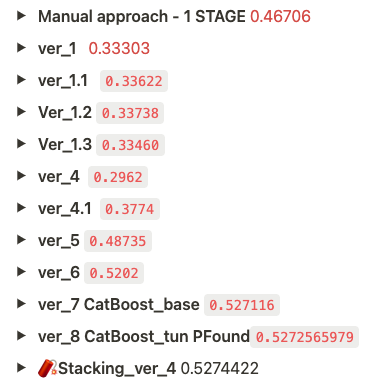

In [4]:
display.Image(f"{main_path}/images/stacking.png")